In [ ]:

#~~~~~~~~~~~~~~~~~~~~~#
#### Prerequisites ####
#~~~~~~~~~~~~~~~~~~~~~#

options(scipen = 999)

library(tidyverse)
library(SummarizedExperiment)
#library(Seurat)
library(Matrix)
library(readxl)
library(ComplexHeatmap)
library(circlize) # For heatmap colors
#library(magick) # For heatmap rasterization
library(mclust) # For adjusted rand index
library("ggpubr")
library(dplyr)
library(treeio)
library(ggtree)

In [424]:
# Function to calculate Shannon entropy

calculate_entropy  <- function(vec) {
  freq_table <- table(vec)                # Count occurrences of each element
  proportions <- freq_table / sum(freq_table)  # Convert counts to proportions
  entropy <- -sum(proportions * log(proportions), na.rm = TRUE)  # Shannon entropy
 
  
  # Handle special case where there's only one unique element
  if (length(freq_table) == 1) {
    entropy <- 0
  } 
  
  return(entropy)
}

# Zhang TCR - P0825 - Top10 - Strongly expanded T cell subpopulations

In [479]:
sample_name = "P0825"
main_dir = paste0("/syn1/wangxin/work/GB_rev/Zhang/", sample_name, "/")
civ_dir = paste0(main_dir, "CIV_top10_strong/")
#create CIV folder for
if (!dir.exists(civ_dir)) {
  # Create the directory
  dir.create(civ_dir, recursive = TRUE)
  }

setwd(main_dir)
df = read.csv(paste0(main_dir,"outs/", sample_name, "_mtSNV_final.csv"), row.names = 1, check.names = F)

meta = read.csv(paste0("/syn1/wangxin/work/GB_rev/Zhang/trust4/", sample_name, "_meta.csv"), row.names = 1, check.names = F, header = T)
meta = meta[as.numeric(sapply(meta$Clone, function(x) {strsplit(x, "_")[[1]][3]}) ) <= 10,]

common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)
af.dm[af.dm < 1] = 0
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time
           

Time difference of 0.1614547 secs

In [480]:
conditions.tib <- tibble(min_clone_size = rep(seq(5, 10, by = 1), 5),
                         min_vaf = rep(c("n1", "n5", "n10", "n20", "n50"), each = 6),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm)) # change this from 0.9 to 0.6 to include more variants
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA

        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code

        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )

        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}

conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls



In [481]:
conditions.tib

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n1,"889G>A, ....",118,TTC70-20....,156,0.8898305
6,n1,"890C>T, ....",85,TTC70-20....,155,0.9058824
7,n1,"890C>T, ....",61,TTC70-20....,154,0.8852459
8,n1,"890C>T, ....",43,TTC70-20....,152,0.8837209
9,n1,"890C>T, ....",36,TTC70-20....,147,0.8611111
10,n1,"890C>T, ....",34,TTC70-20....,144,0.8529412
5,n5,"1583A>G,....",14,PTC131-2....,84,0.8571429
6,n5,"1583A>G,....",12,PTC131-2....,75,0.9166667
7,n5,"1583A>G,....",11,PTC131-2....,71,0.9090909


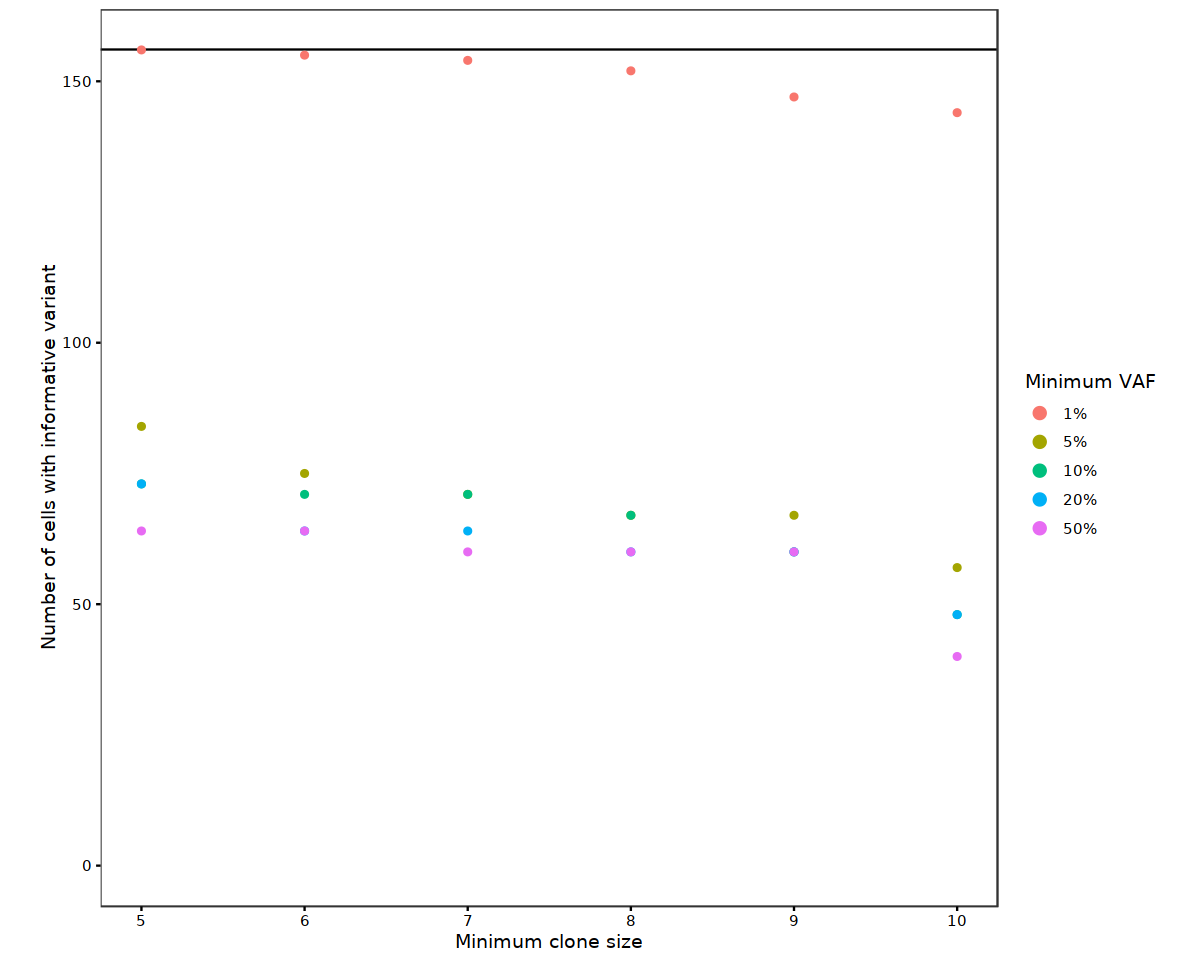

In [482]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "20%", "50%")))

ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [483]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(5, 10), min_vaf %in% c("n5","n10", "n20"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"1583A>G,....",14,PTC131-2....,84,0.8571429
10,n5,"1583A>G,....",8,PTC131-2....,57,0.8750000
5,n10,"1583A>G,....",12,PTC131-2....,73,0.9166667
10,n10,"2619A>G,....",7,PTC16-20....,48,0.8571429
5,n20,"1583A>G,....",12,PTC131-2....,73,0.9166667
10,n20,"2619A>G,....",7,PTC16-20....,48,0.8571429


## min clone 5 min vaf 5%

In [484]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=1
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



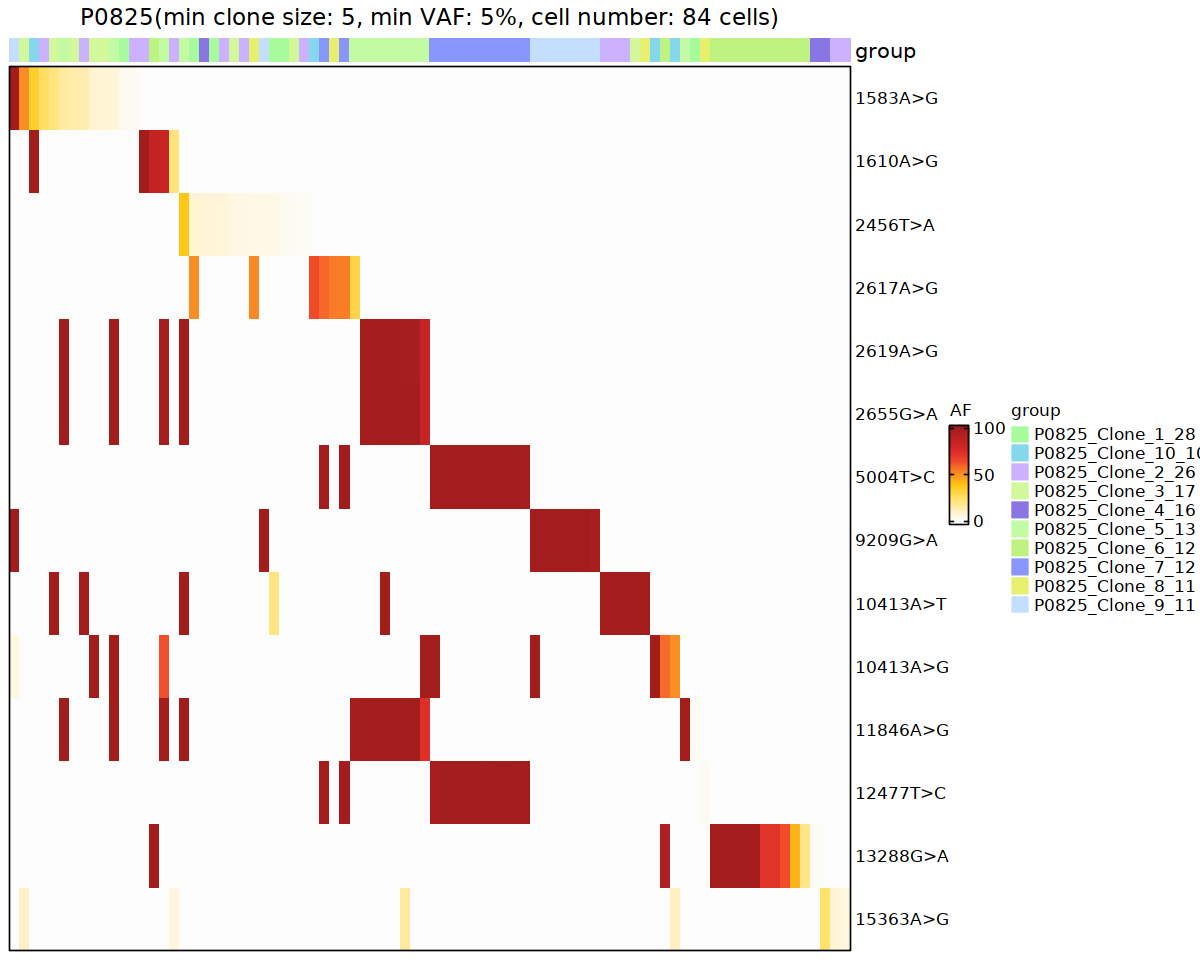

In [485]:
options(repr.plot.width=10, repr.plot.height=8)
ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
#ha <- HeatmapAnnotation(df = ct_plot_df, col = list(group = ct_pal))
ha <- HeatmapAnnotation(df = ct_plot_df)
clone_size_cutoff = conditions_subset.tib$min_clone_size[a]
vaf_cutoff = substr(conditions_subset.tib$min_vaf[a],2,nchar(conditions_subset.tib$min_vaf[a]))
my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(plot_order.mat)," cells)")
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(240, "mm"),
               #height = unit(200, "mm"),
               use_raster = T,
               raster_quality = 5)

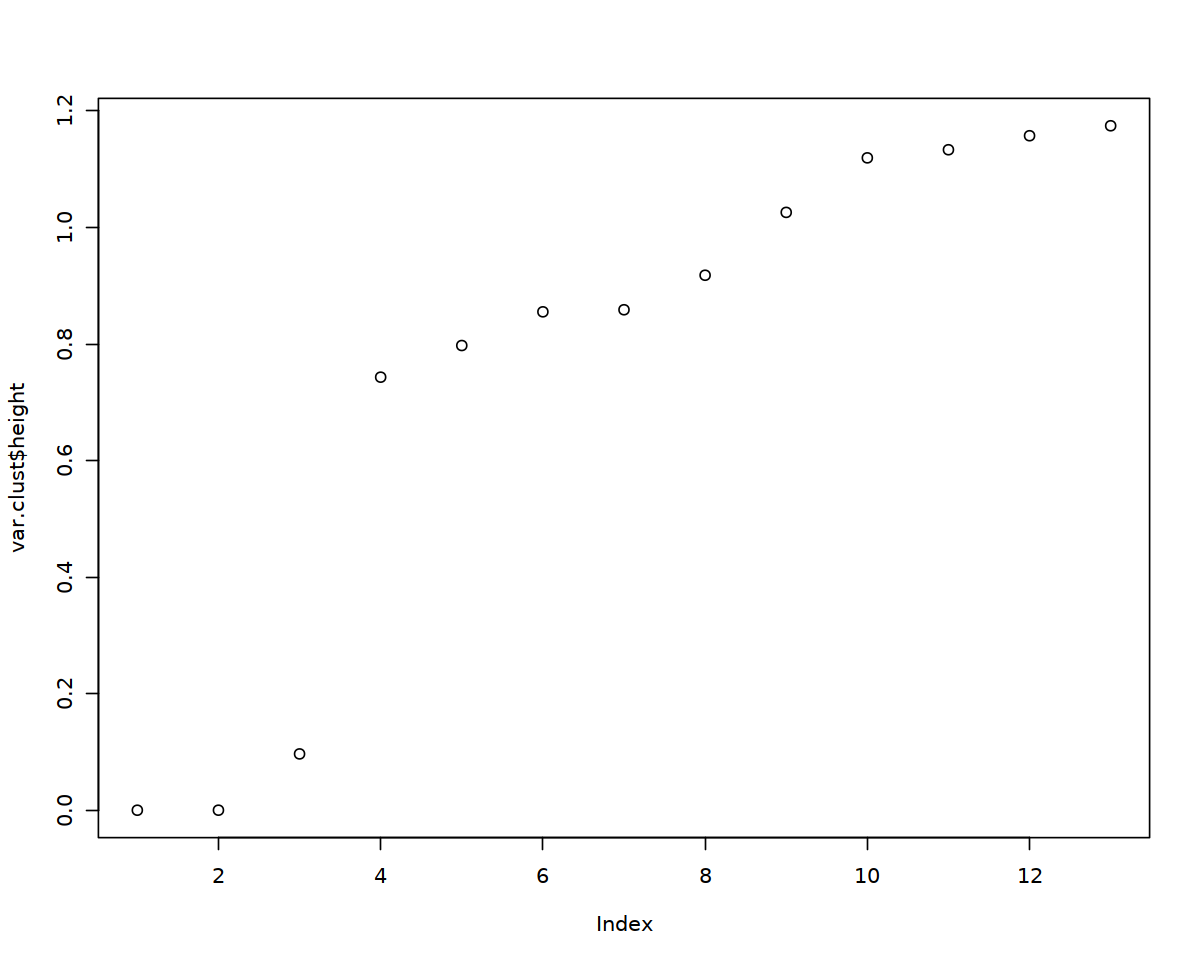

In [486]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

plot(var.clust$height, ylim = c(0, max(var.clust$height)))

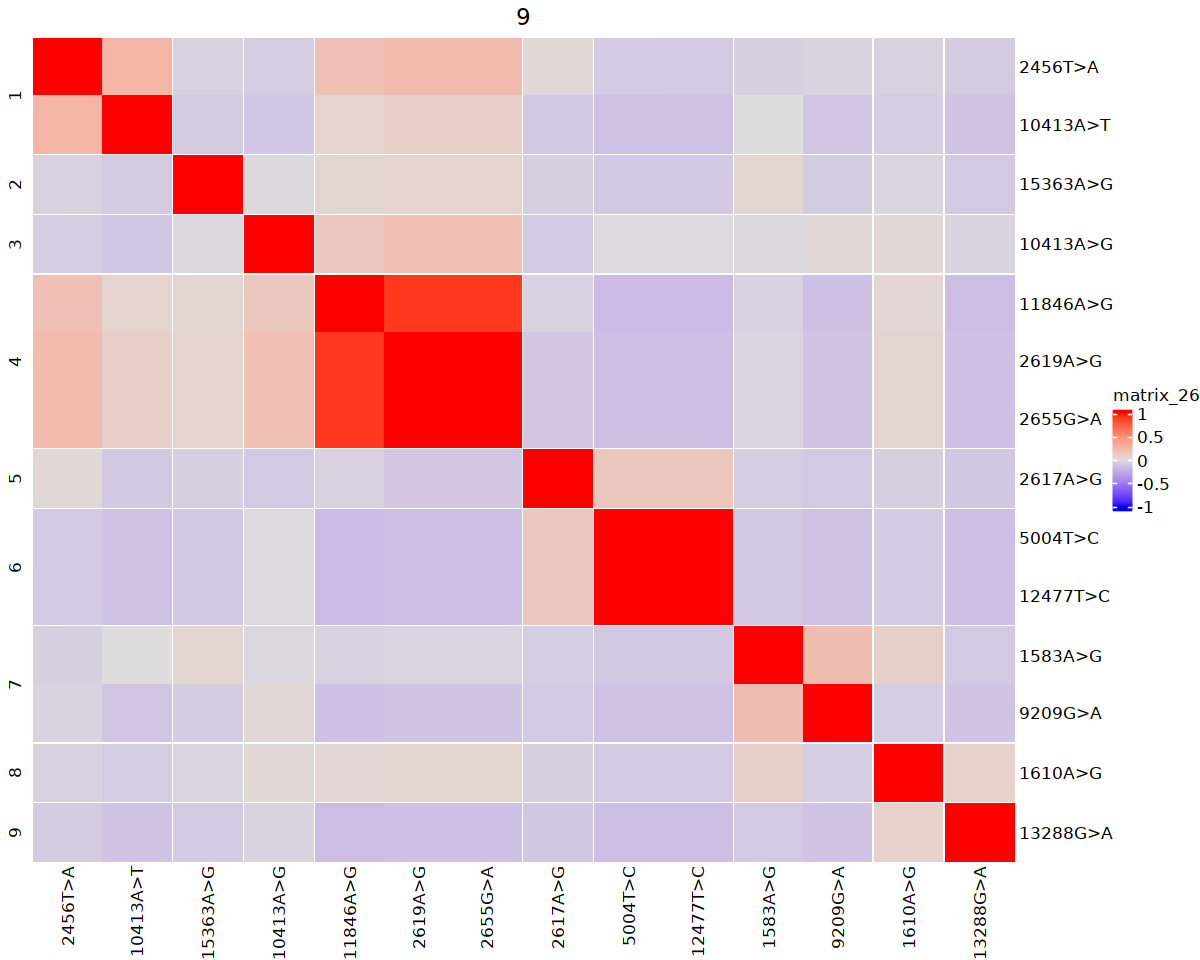

In [487]:

ngroups = length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



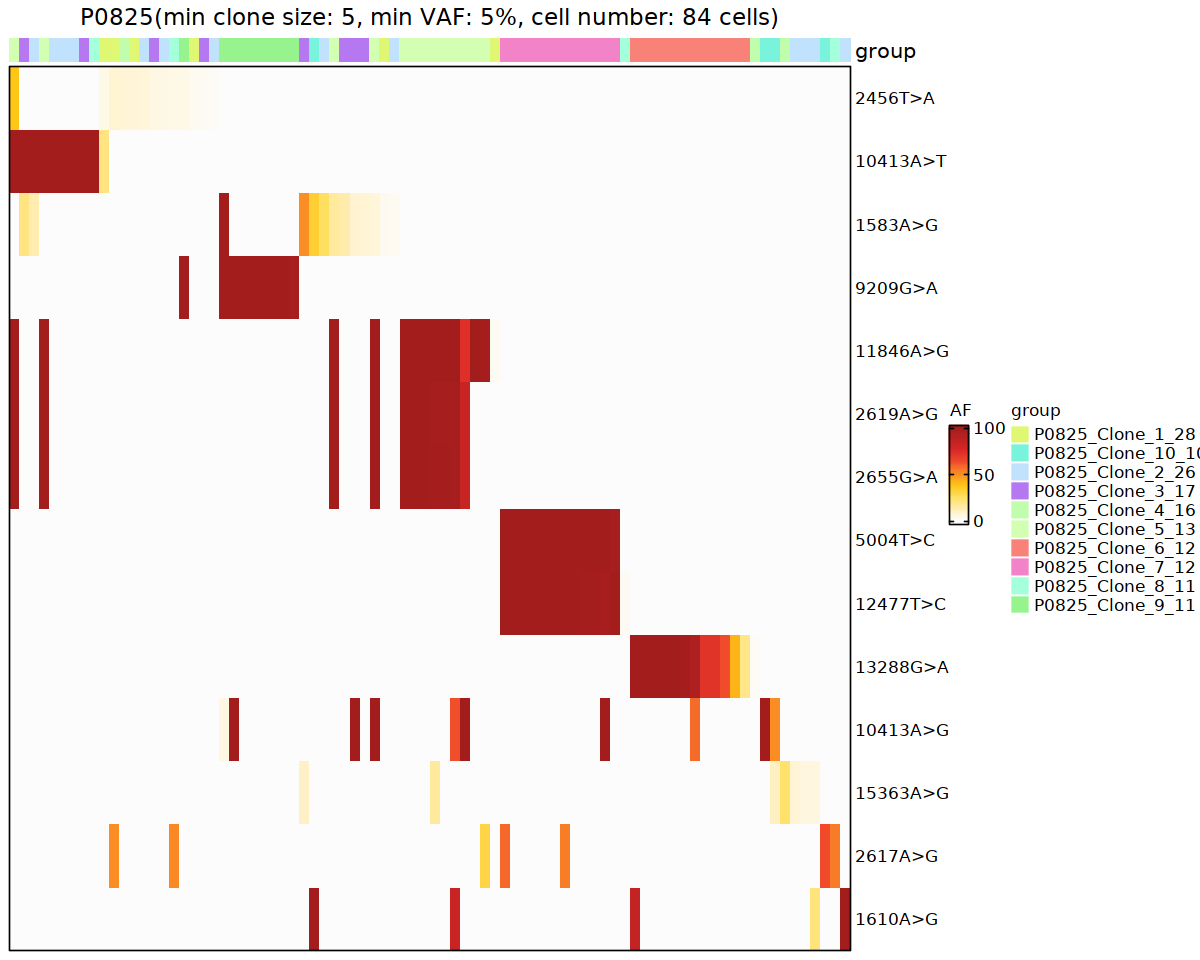

In [488]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

                                   
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

In [489]:

tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))

#remove clones with only one cell.
cell_num_dict = table(clone_info_df$Clone)
passed_CIV = c()
for (civ in CIV) {
    if (cell_num_dict[civ] >=2) {
        passed_CIV = append(passed_CIV, civ)
    }
}

small_clone_num = length(CIV) - length(passed_CIV)
CIV = passed_CIV
keep_cells = clone_info_df[clone_info_df$Clone %in% CIV, "Cell"]
small_clone_cell_num = ncol(new2) - length(keep_cells)
message(paste0("Removed ", small_clone_num, " small clones, and ", small_clone_cell_num, " cells falling within the small clones were removed."))
#remove cells from the small clones 
clone_info_df = clone_info_df[clone_info_df$Clone %in% CIV, ]
new2 = new2[CIV, keep_cells]
      
CIV_file_name = paste0(civ_dir,"/strong_exp_CIV_clones_", sample_name, ".csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)
new_plot_mat = new2


Removed 0 small clones, and 0 cells falling within the small clones were removed.

Clone info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10_strong//strong_exp_CIV_clones_P0825.csv



In [490]:
new_plot_mat1 = new_plot_mat/100 

all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.01]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.01]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(civ_dir,"/strong_exp_meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10_strong//strong_exp_meanvar_CIV_P0825.csv



In [491]:
shannon_e = c()

for (i in CIV) {
    cell = clone_info_df[clone_info_df$Clone == i, "Cell"]
    colony_comp = meta[cell, "Clone"]
    shannon_e = append(shannon_e, calculate_entropy(colony_comp))
}
diversity_df = data.frame(Diversity=shannon_e, row.names = CIV)
diversity_file_name = paste0(civ_dir,"/strong_exp_diversity_CIV_", sample_name, ".csv")
write.csv(diversity_df, file = diversity_file_name, quote =F)
message("Diversity info has been saved to: ", diversity_file_name)

Diversity info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10_strong//strong_exp_diversity_CIV_P0825.csv



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


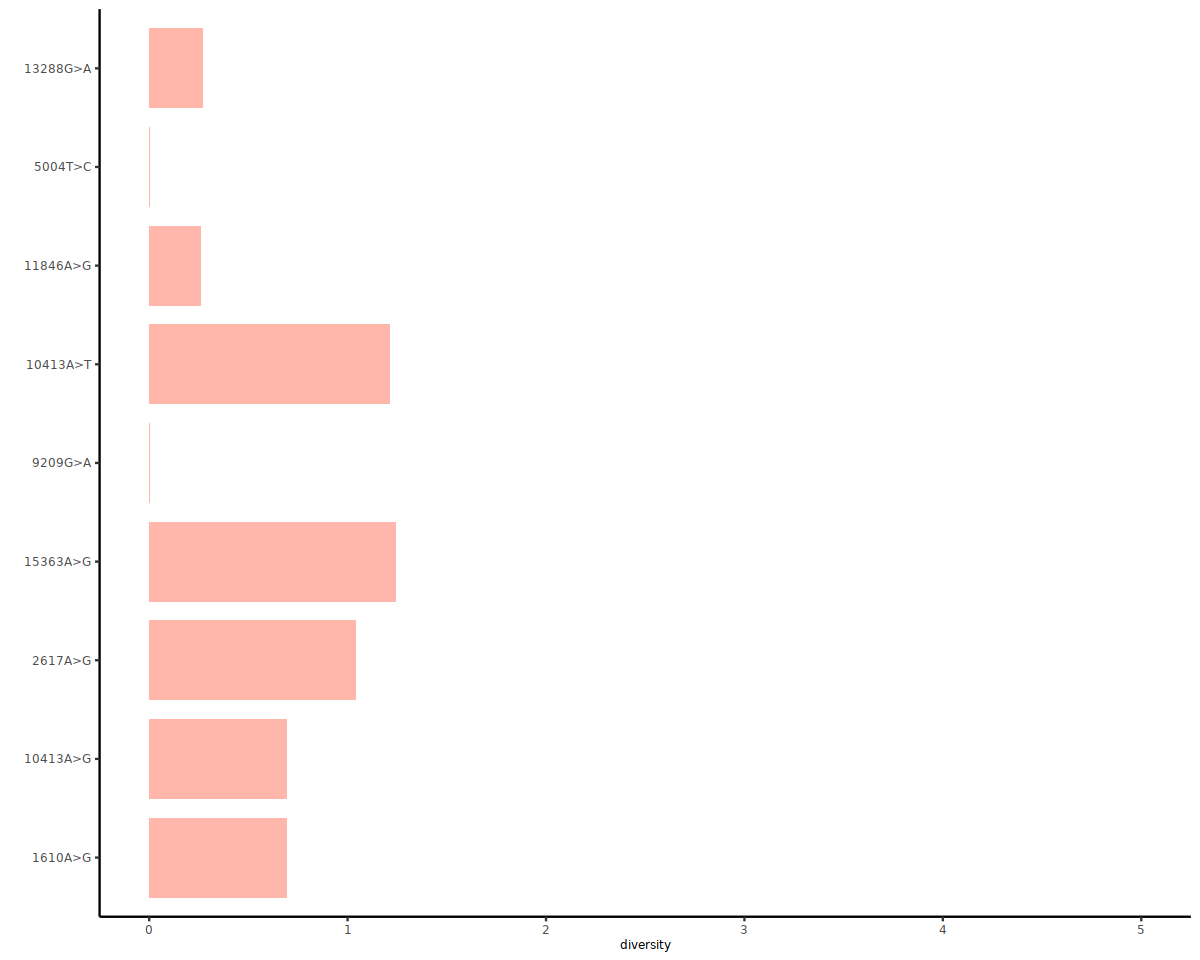

In [492]:
plot_df = data.frame(variant=CIV, diversity = shannon_e)
plot_df$variant = factor(plot_df$variant, levels = rev(CIV) )
diversity_plot = ggplot(plot_df, aes(x=variant, y=diversity)) + geom_bar(stat="identity", fill = "#ff715b", alpha=0.5, width = 0.8) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7)) + xlab("") + 
  scale_y_continuous(breaks = seq(0, 5, 0.5)) + ylim (0, 5)+ coord_flip()
diversity_plot
ggsave(plot = diversity_plot, file = paste0(civ_dir, "/strong_exp_diversity_plot.pdf"), height = 3, width = 3)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10_strong/P0825_strong_exp_CIV_heatmap.pdf



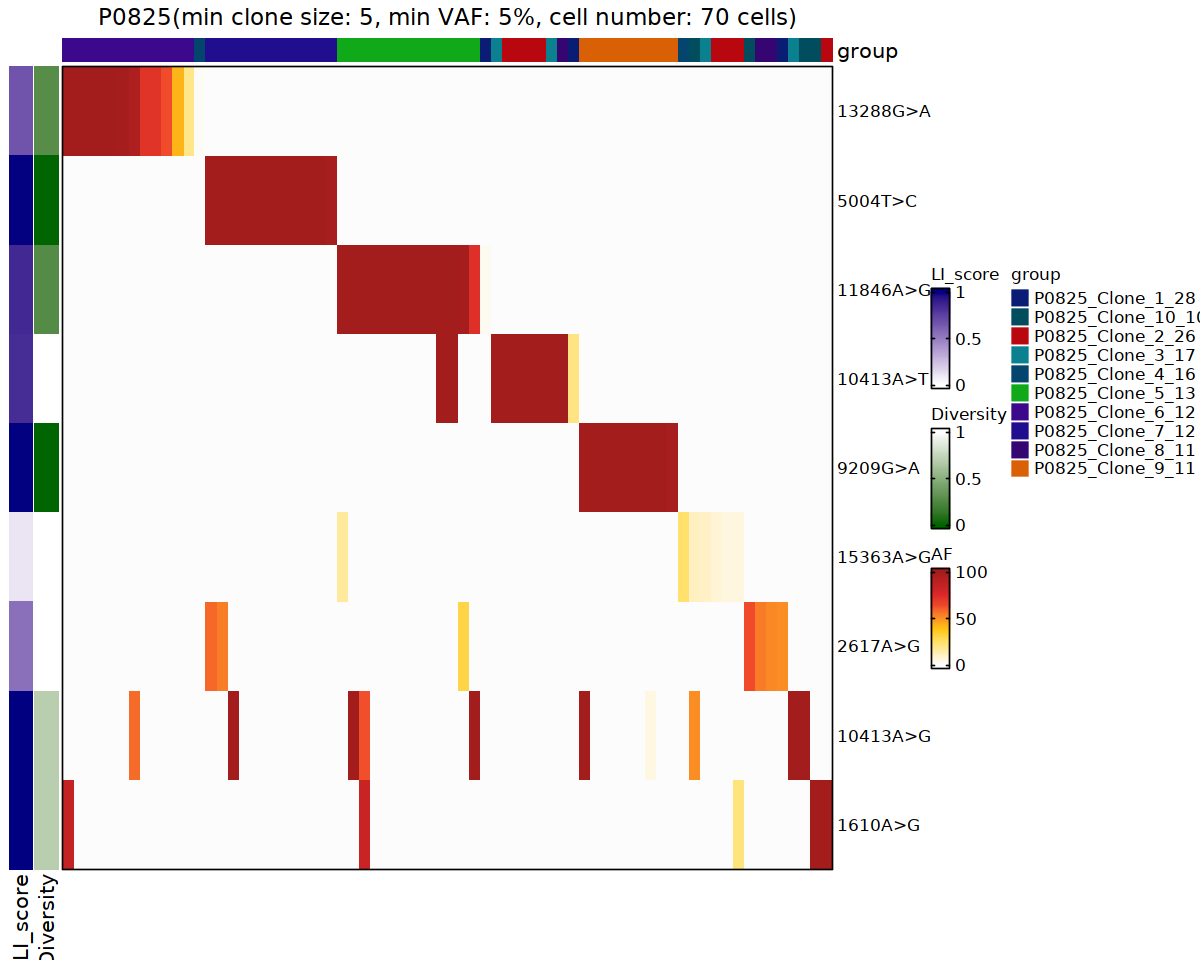

In [493]:
col_pal1 = colorRamp2(c(0, 1), c( "white", "navyblue"))
col_pal2 = colorRamp2(c(0, 1), c( "darkgreen", "white"))
row_annot <- rowAnnotation(
  df = data.frame(LI_score = sub_mv1_ls, Diversity = shannon_e),
  col = list(LI_score = col_pal1, Diversity = col_pal2), annotation_legend_param = list(border = "#000000"))

ct_plot_df = as.data.frame(tibble(group=meta[colnames(new_plot_mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(new_plot_mat)," cells)")
htmap_p = Heatmap(new_plot_mat, column_title = my_title, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
                  left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p

heatmap_name = paste0(civ_dir, sample_name,"_strong_exp_CIV_heatmap.pdf")
pdf(heatmap_name, height = 2.645, width = 4.5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))


# Zhang TCR - P0825 - Top10 excluded - Weakly expanded T cell subpopulations

In [460]:
sample_name = "P0825"
main_dir = paste0("/syn1/wangxin/work/GB_rev/Zhang/", sample_name, "/")
civ_dir = paste0(main_dir, "CIV_top10excluded_weak/")
#create CIV folder for
if (!dir.exists(civ_dir)) {
  # Create the directory
  dir.create(civ_dir, recursive = TRUE)
  }

setwd(main_dir)
df = read.csv(paste0(main_dir,"outs/", sample_name, "_mtSNV_final.csv"), row.names = 1, check.names = F)

meta = read.csv(paste0("/syn1/wangxin/work/GB_rev/Zhang/trust4/", sample_name, "_meta.csv"), row.names = 1, check.names = F, header = T)
meta = meta[as.numeric(sapply(meta$Clone, function(x) {strsplit(x, "_")[[1]][3]}) ) > 10,]

common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)
af.dm[af.dm < 1] = 0
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time
           

Time difference of 1.201082 secs

In [461]:
conditions.tib <- tibble(min_clone_size = rep(seq(5, 10, by = 1), 5),
                         min_vaf = rep(c("n1", "n5", "n10", "n20", "n50"), each = 6),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm)) # change this from 0.9 to 0.6 to include more variants
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA

        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code

        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )

        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}

conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls



In [462]:
conditions.tib

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n1,"701G>A, ....",1039,TTC147-2....,1015,0.9066410
6,n1,"701G>A, ....",804,TTC147-2....,1015,0.9141791
7,n1,"701G>A, ....",637,TTC147-2....,1015,0.9230769
8,n1,"701G>A, ....",549,TTC147-2....,1015,0.9216758
9,n1,"701G>A, ....",468,TTC147-2....,1014,0.9166667
10,n1,"701G>A, ....",421,TTC147-2....,1014,0.9168646
5,n5,"727T>C, ....",113,TTC147-2....,959,0.7610619
6,n5,"727T>C, ....",73,TTC147-2....,897,0.7397260
7,n5,"786G>A, ....",52,TTC147-2....,804,0.7307692


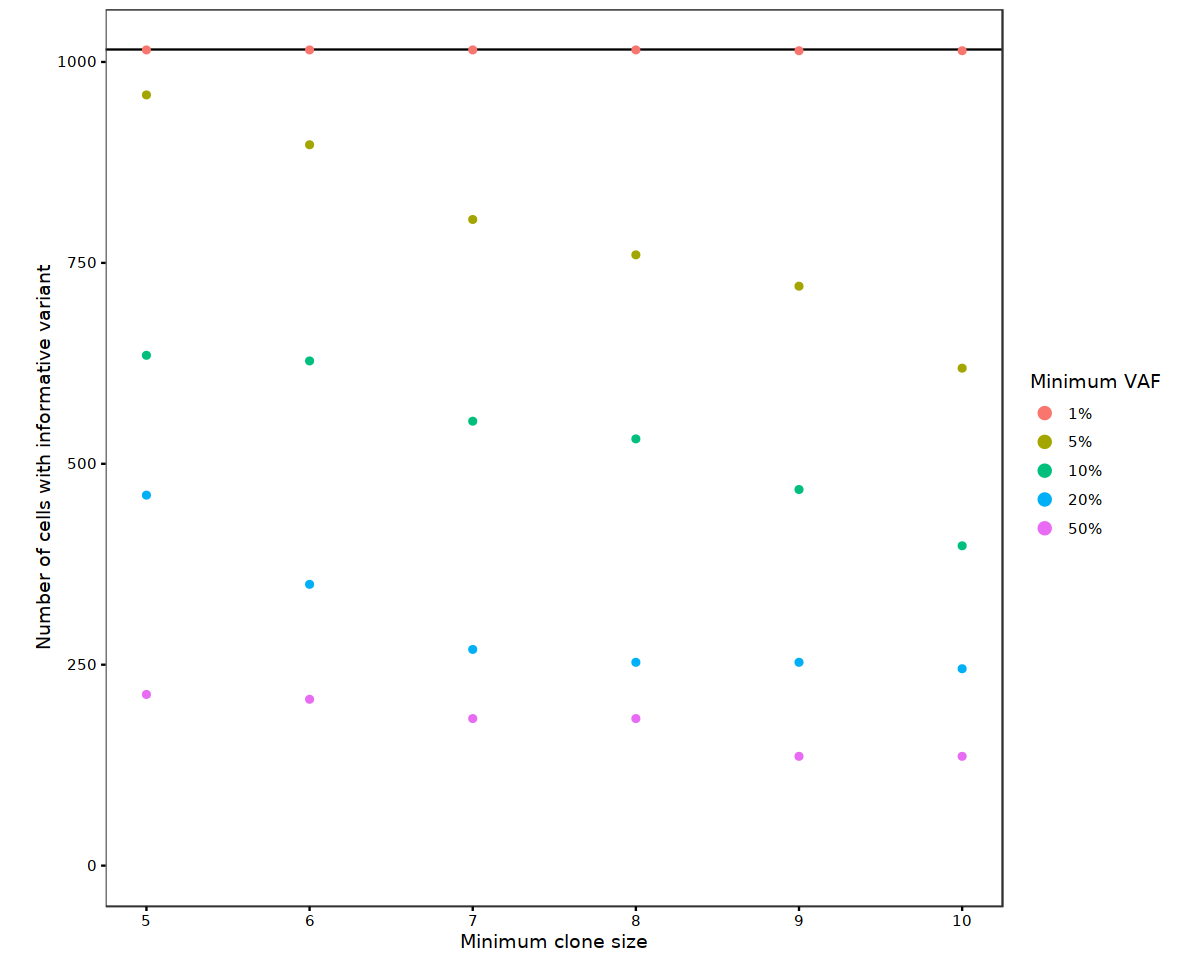

In [463]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "20%", "50%")))

ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [464]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(5, 10), min_vaf %in% c("n5","n10", "n20"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"727T>C, ....",113,TTC147-2....,959,0.7610619
10,n5,"929A>G, ....",25,TTC147-2....,619,0.7600000
5,n10,"811G>A, ....",34,TTC147-2....,635,0.7647059
10,n10,"1583A>G,....",11,TTC147-2....,398,0.7272727
5,n20,"811G>A, ....",23,TTC147-2....,461,0.7391304
10,n20,"1583A>G,....",7,TTC147-2....,245,0.8571429


## min clone 10 min vaf 5%

In [465]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=2
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



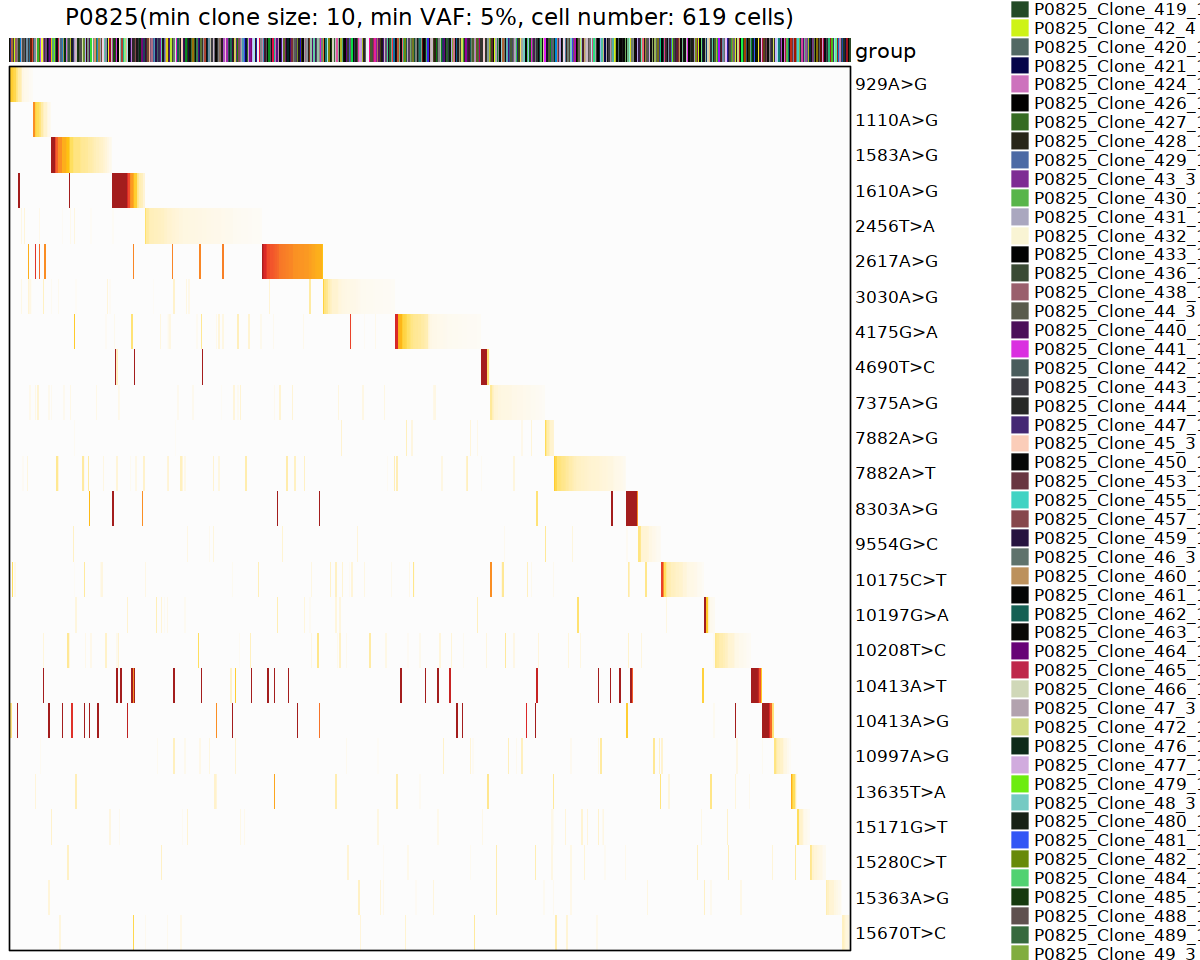

In [466]:
options(repr.plot.width=10, repr.plot.height=8)
ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
#ha <- HeatmapAnnotation(df = ct_plot_df, col = list(group = ct_pal))
ha <- HeatmapAnnotation(df = ct_plot_df)
clone_size_cutoff = conditions_subset.tib$min_clone_size[a]
vaf_cutoff = substr(conditions_subset.tib$min_vaf[a],2,nchar(conditions_subset.tib$min_vaf[a]))
my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(plot_order.mat)," cells)")
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(240, "mm"),
               #height = unit(200, "mm"),
               use_raster = T,
               raster_quality = 5)

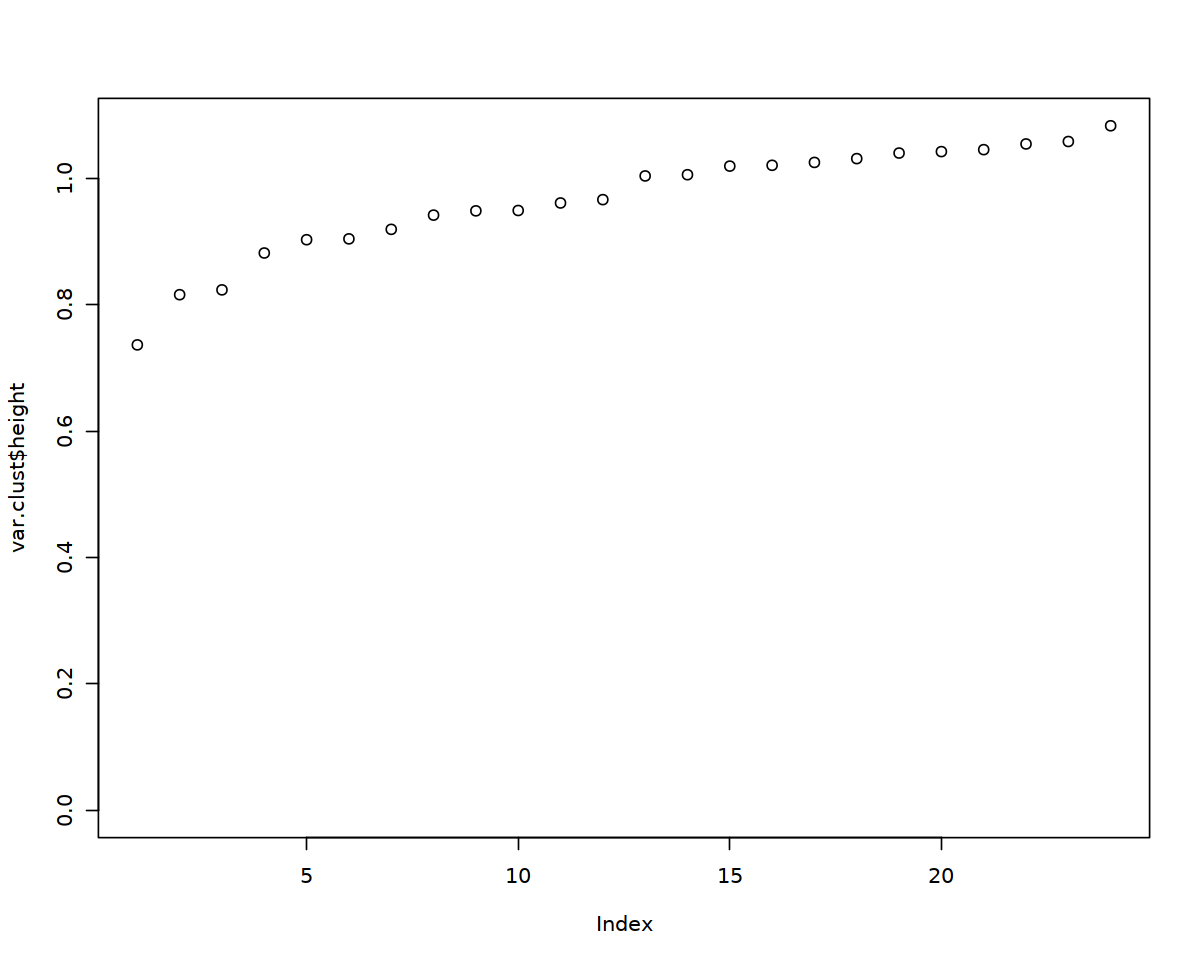

In [467]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

plot(var.clust$height, ylim = c(0, max(var.clust$height)))

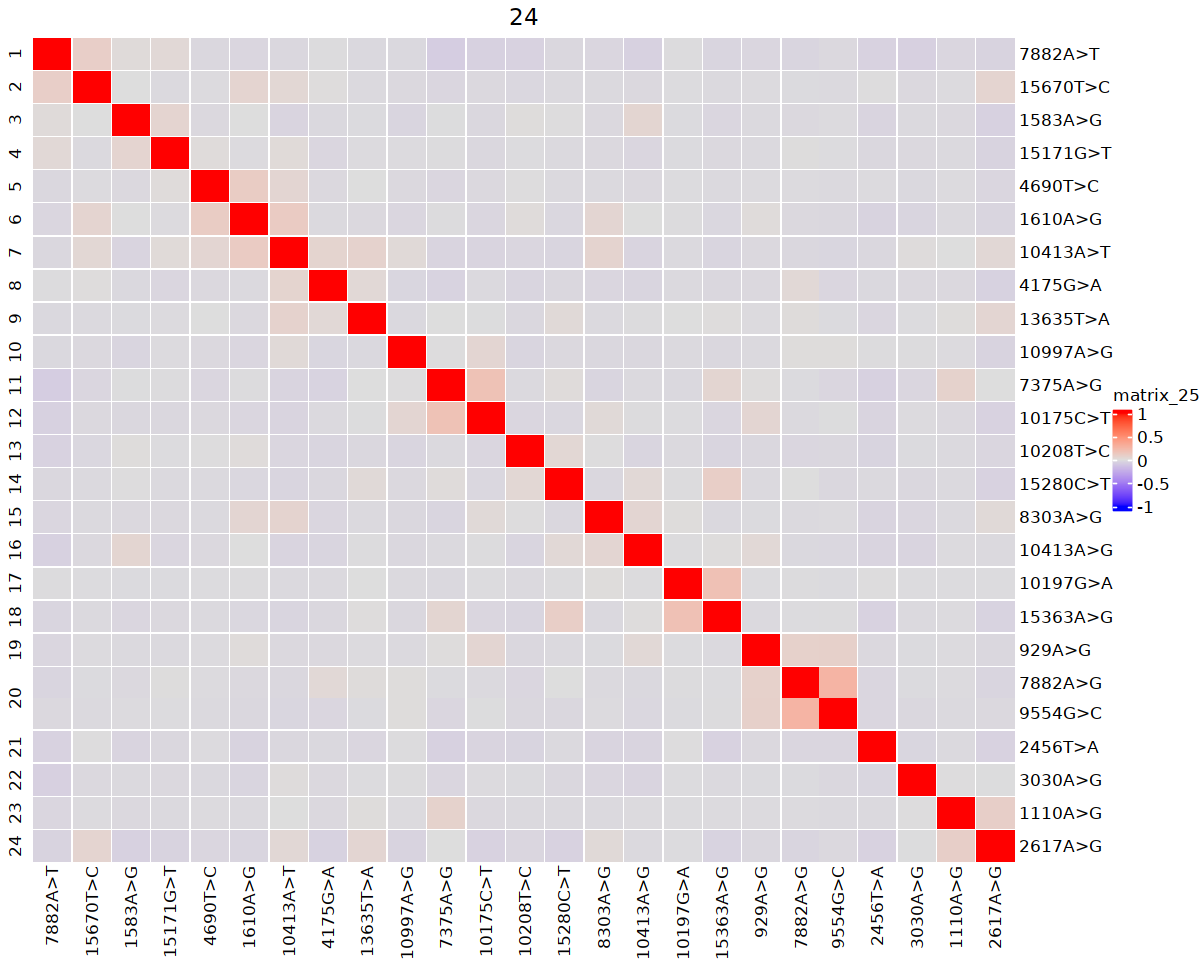

In [468]:

ngroups = length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



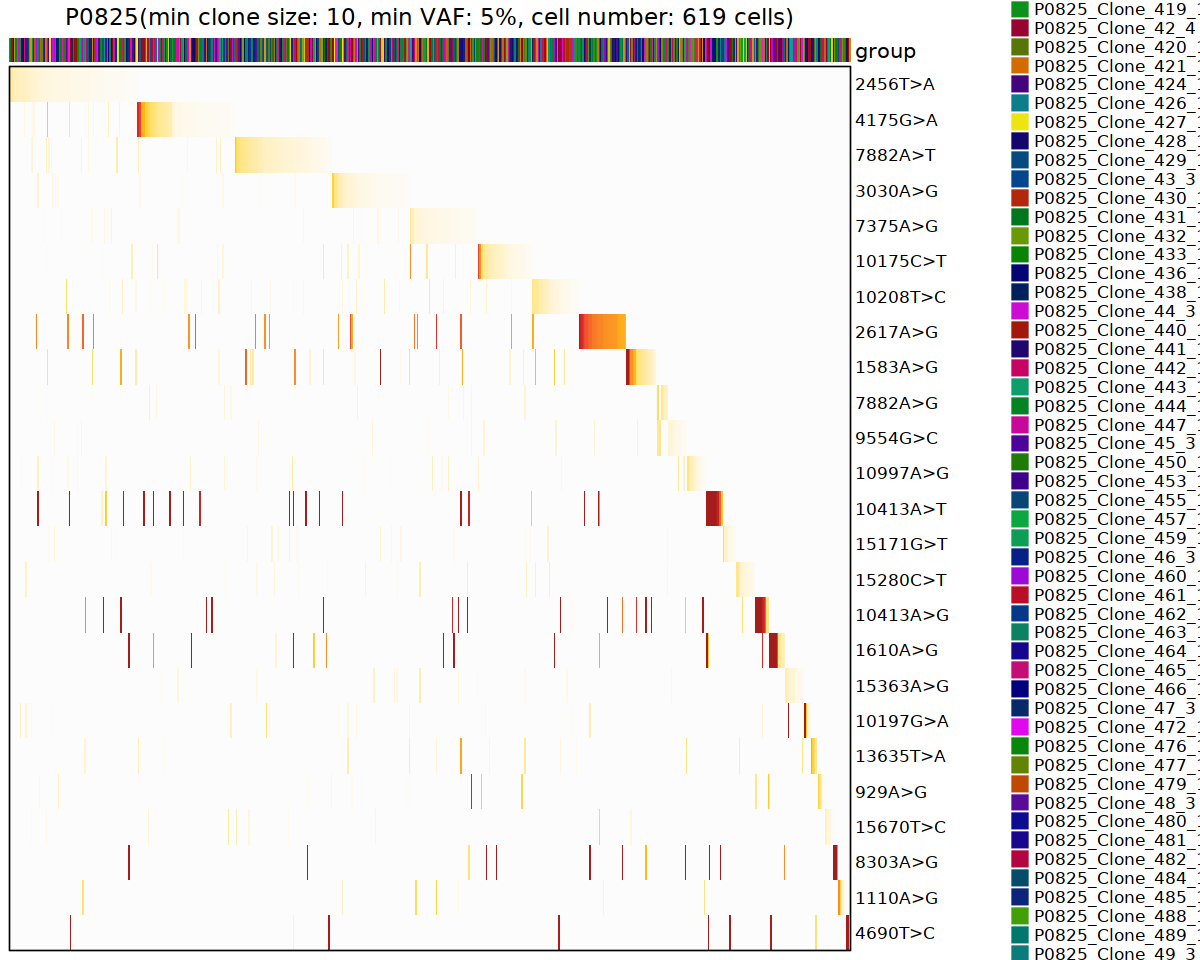

In [469]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

                                   
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

In [470]:

tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))

#remove clones with only one cell.
cell_num_dict = table(clone_info_df$Clone)
passed_CIV = c()
for (civ in CIV) {
    if (cell_num_dict[civ] >=2) {
        passed_CIV = append(passed_CIV, civ)
    }
}

small_clone_num = length(CIV) - length(passed_CIV)
CIV = passed_CIV
keep_cells = clone_info_df[clone_info_df$Clone %in% CIV, "Cell"]
small_clone_cell_num = ncol(new2) - length(keep_cells)
message(paste0("Removed ", small_clone_num, " small clones, and ", small_clone_cell_num, " cells falling within the small clones were removed."))
#remove cells from the small clones 
clone_info_df = clone_info_df[clone_info_df$Clone %in% CIV, ]
new2 = new2[CIV, keep_cells]
      
CIV_file_name = paste0(civ_dir,"/strong_exp_CIV_clones_", sample_name, ".csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)
new_plot_mat = new2


Removed 0 small clones, and 0 cells falling within the small clones were removed.

Clone info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10excluded_weak//strong_exp_CIV_clones_P0825.csv



In [471]:
new_plot_mat1 = new_plot_mat/100 

all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.01]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.01]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(civ_dir,"/strong_exp_meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10excluded_weak//strong_exp_meanvar_CIV_P0825.csv



In [472]:
shannon_e = c()

for (i in CIV) {
    cell = clone_info_df[clone_info_df$Clone == i, "Cell"]
    colony_comp = meta[cell, "Clone"]
    shannon_e = append(shannon_e, calculate_entropy(colony_comp))
}
diversity_df = data.frame(Diversity=shannon_e, row.names = CIV)
diversity_file_name = paste0(civ_dir,"/strong_exp_diversity_CIV_", sample_name, ".csv")
write.csv(diversity_df, file = diversity_file_name, quote =F)
message("Diversity info has been saved to: ", diversity_file_name)

Diversity info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10excluded_weak//strong_exp_diversity_CIV_P0825.csv



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


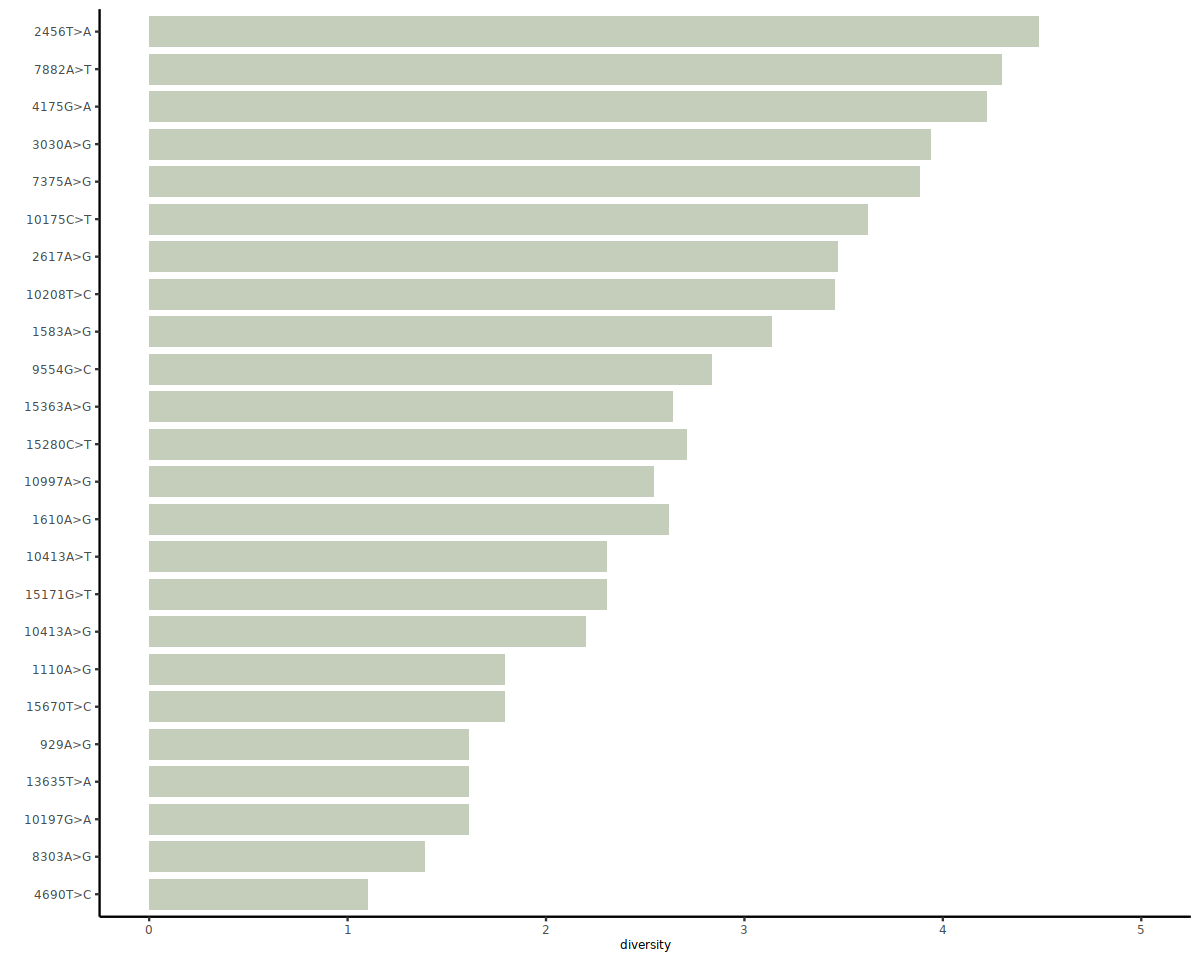

In [473]:
plot_df = data.frame(variant=CIV, diversity = shannon_e)
plot_df$variant = factor(plot_df$variant, levels = rev(CIV) )
diversity_plot = ggplot(plot_df, aes(x=variant, y=diversity)) + geom_bar(stat="identity", fill = "#899d78", alpha=0.5, width = 0.8) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7)) + xlab("") + 
  scale_y_continuous(breaks = seq(0, 5, 0.5)) + ylim(0, 5) + coord_flip()
diversity_plot
ggsave(plot = diversity_plot, file = paste0(civ_dir, "/strong_exp_diversity_plot.pdf"), height = 3, width = 3)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0825/CIV_top10excluded_weak/P0825_weak_exp_CIV_heatmap.pdf



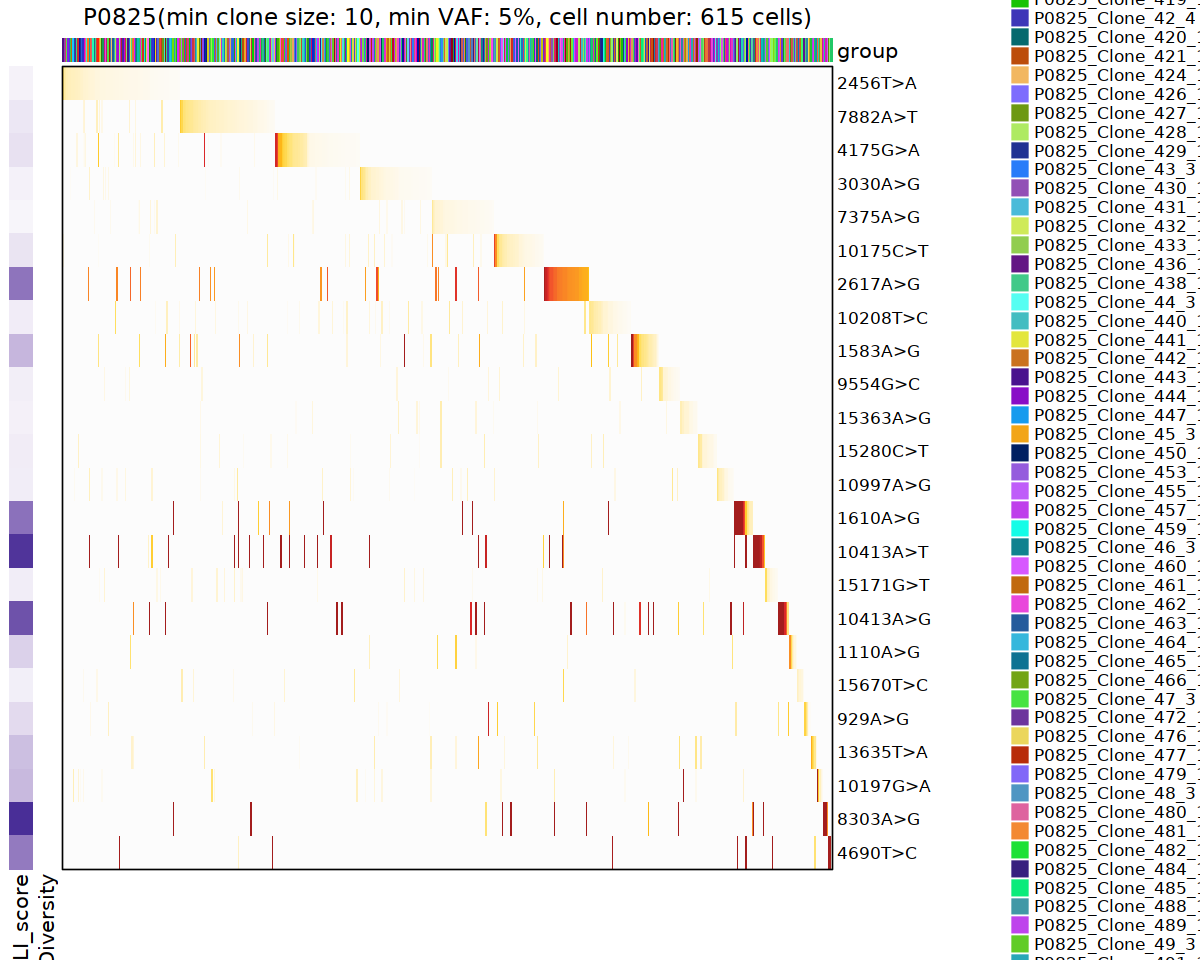

In [478]:
col_pal1 = colorRamp2(c(0, 1), c( "white", "navyblue"))
col_pal2 = colorRamp2(c(0, 1), c( "darkgreen", "white"))
row_annot <- rowAnnotation(
  df = data.frame(LI_score = sub_mv1_ls, Diversity = shannon_e),
  col = list(LI_score = col_pal1, Diversity = col_pal2), annotation_legend_param = list(border = "#000000"))

ct_plot_df = as.data.frame(tibble(group=meta[colnames(new_plot_mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(new_plot_mat)," cells)")
htmap_p = Heatmap(new_plot_mat, column_title = my_title, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
                  left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p

heatmap_name = paste0(civ_dir, sample_name,"_weak_exp_CIV_heatmap.pdf")
pdf(heatmap_name, height = 2.645, width = 4.5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))


# Zhang TCR - P0123 - Top10 - Strongly expanded T cell subpopulations

In [568]:
sample_name = "P0123"
main_dir = paste0("/syn1/wangxin/work/GB_rev/Zhang/", sample_name, "/")
civ_dir = paste0(main_dir, "CIV_top10_strong/")
#create CIV folder for
if (!dir.exists(civ_dir)) {
  # Create the directory
  dir.create(civ_dir, recursive = TRUE)
  }

setwd(main_dir)
df = read.csv(paste0(main_dir,"outs/", sample_name, "_mtSNV_final.csv"), row.names = 1, check.names = F)

meta = read.csv(paste0("/syn1/wangxin/work/GB_rev/Zhang/trust4/", sample_name, "_meta.csv"), row.names = 1, check.names = F, header = T)
meta = meta[as.numeric(sapply(meta$Clone, function(x) {strsplit(x, "_")[[1]][3]}) ) <= 10,]

common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)
af.dm[af.dm < 1] = 0
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time
           

Time difference of 0.3673475 secs

In [569]:
conditions.tib <- tibble(min_clone_size = rep(seq(5, 10, by = 1), 5),
                         min_vaf = rep(c("n1", "n5", "n10", "n20", "n50"), each = 6),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm)) # change this from 0.9 to 0.6 to include more variants
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA

        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code

        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )

        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}

conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls



In [570]:
conditions.tib

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n1,"747A>G, ....",161,PTC34-20....,159,0.9316770
6,n1,"747A>G, ....",115,PTC34-20....,159,0.9304348
7,n1,"747A>G, ....",84,PTC34-20....,159,0.9166667
8,n1,"747A>G, ....",61,PTC34-20....,159,0.9016393
9,n1,"747A>G, ....",51,PTC34-20....,158,0.8823529
10,n1,"747A>G, ....",42,PTC34-20....,155,0.9285714
5,n5,"929A>G, ....",6,PTC27-20....,56,0.8333333
6,n5,"2596G>A,....",4,PTC27-20....,43,0.7500000
7,n5,"2596G>A,....",4,PTC27-20....,43,0.7500000


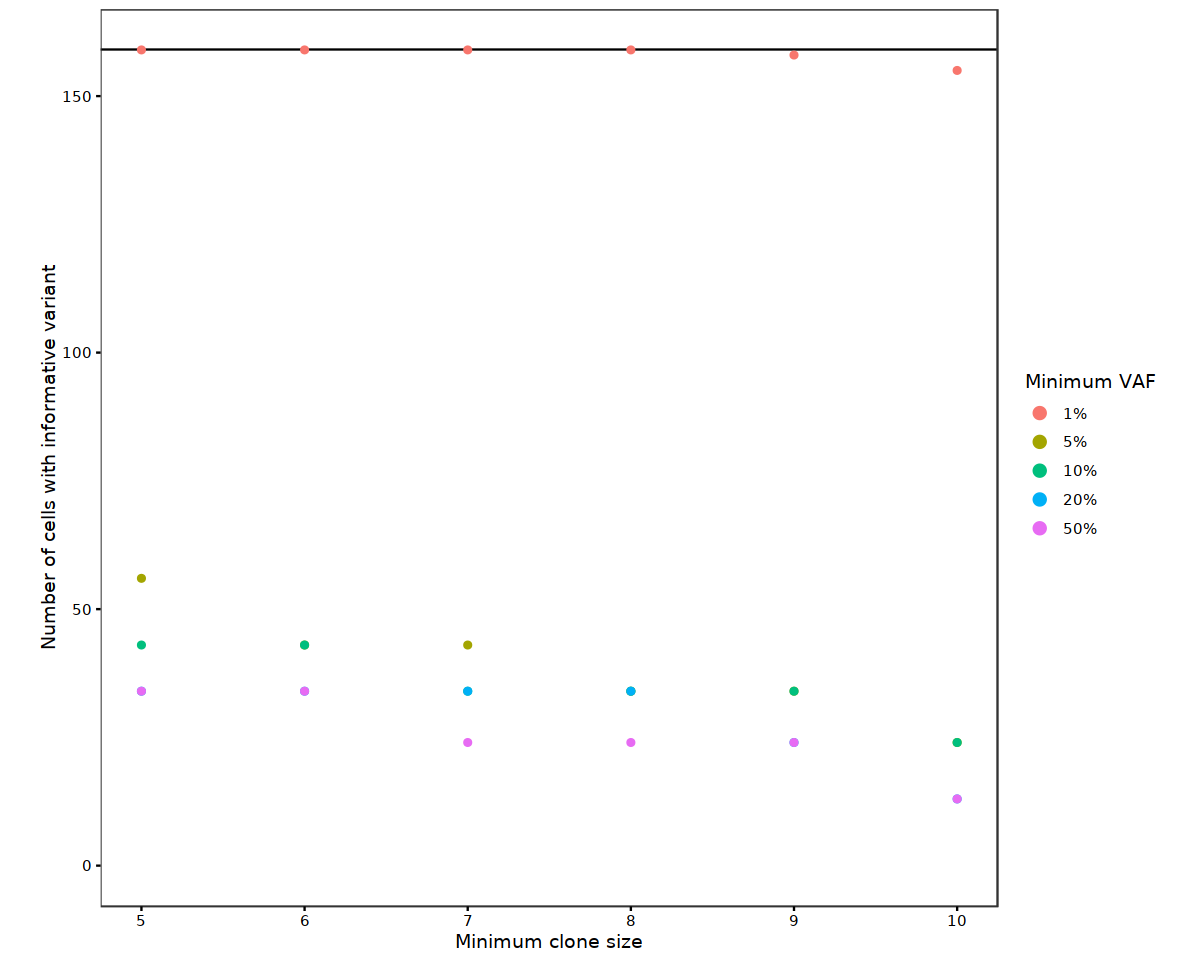

In [571]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "20%", "50%")))

ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [572]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(5, 10), min_vaf %in% c("n5","n10", "n20"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"929A>G, ....",6,PTC27-20....,56,0.8333333
10,n5,"5746G>A,....",2,PTC27-20....,24,1.0000000
5,n10,"2596G>A,....",4,PTC27-20....,43,0.7500000
10,n10,"5746G>A,....",2,PTC27-20....,24,1.0000000
5,n20,"2596G>A,....",3,PTC27-20....,34,1.0000000
10,n20,8470A>G,1,TTC10-20....,13,1.0000000


## min clone 5 min vaf 5%

In [573]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=1
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



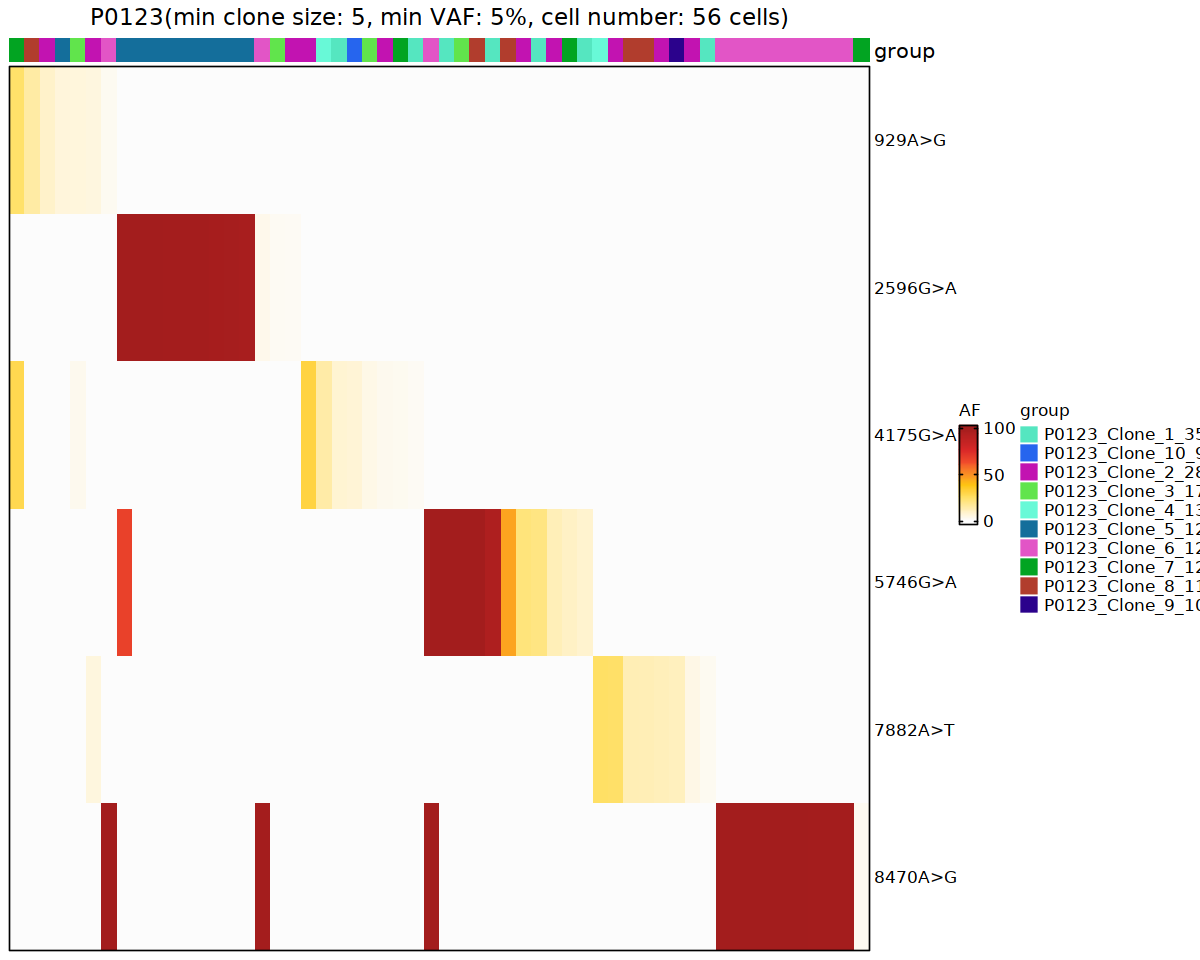

In [574]:
options(repr.plot.width=10, repr.plot.height=8)
ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
#ha <- HeatmapAnnotation(df = ct_plot_df, col = list(group = ct_pal))
ha <- HeatmapAnnotation(df = ct_plot_df)
clone_size_cutoff = conditions_subset.tib$min_clone_size[a]
vaf_cutoff = substr(conditions_subset.tib$min_vaf[a],2,nchar(conditions_subset.tib$min_vaf[a]))
my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(plot_order.mat)," cells)")
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(240, "mm"),
               #height = unit(200, "mm"),
               use_raster = T,
               raster_quality = 5)

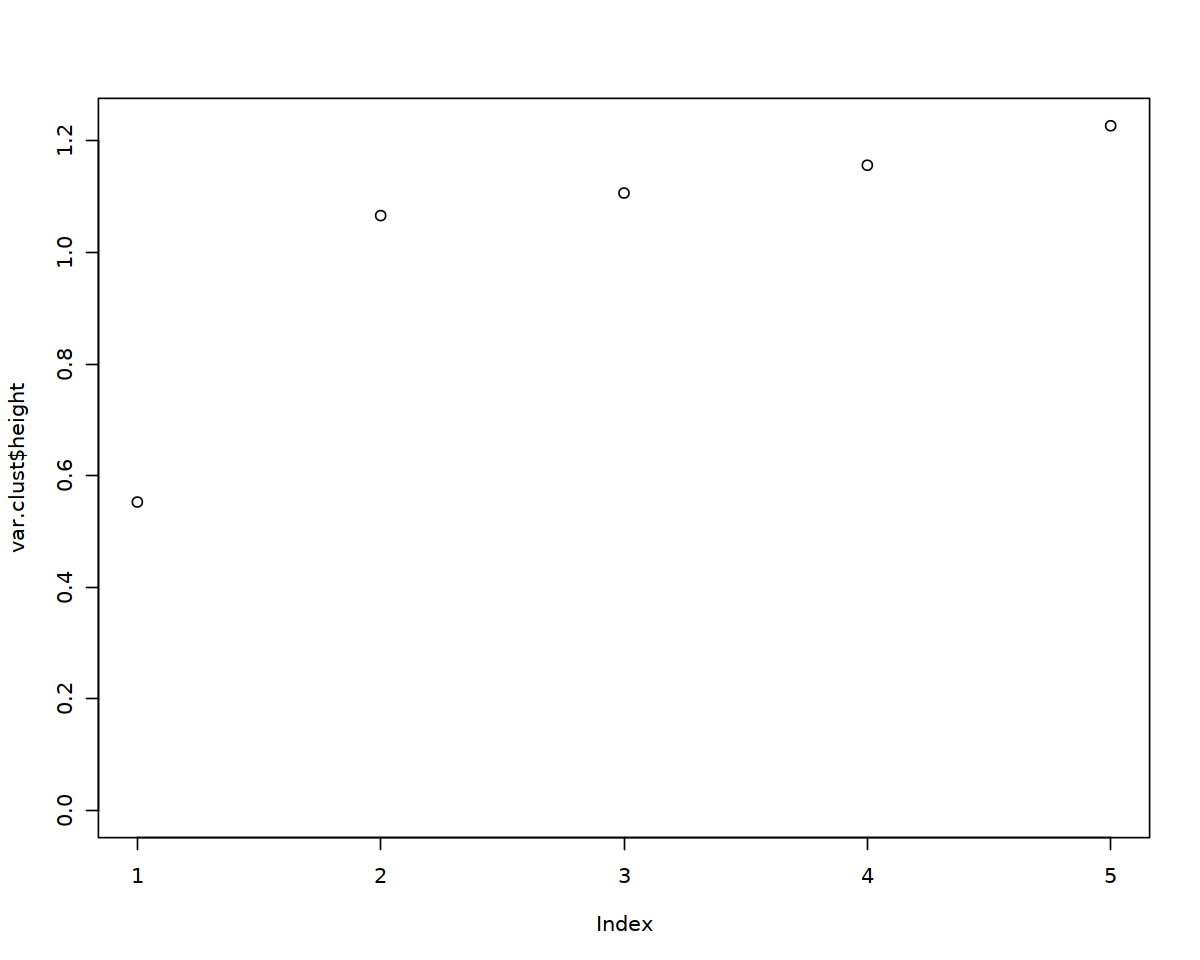

In [575]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

plot(var.clust$height, ylim = c(0, max(var.clust$height)))

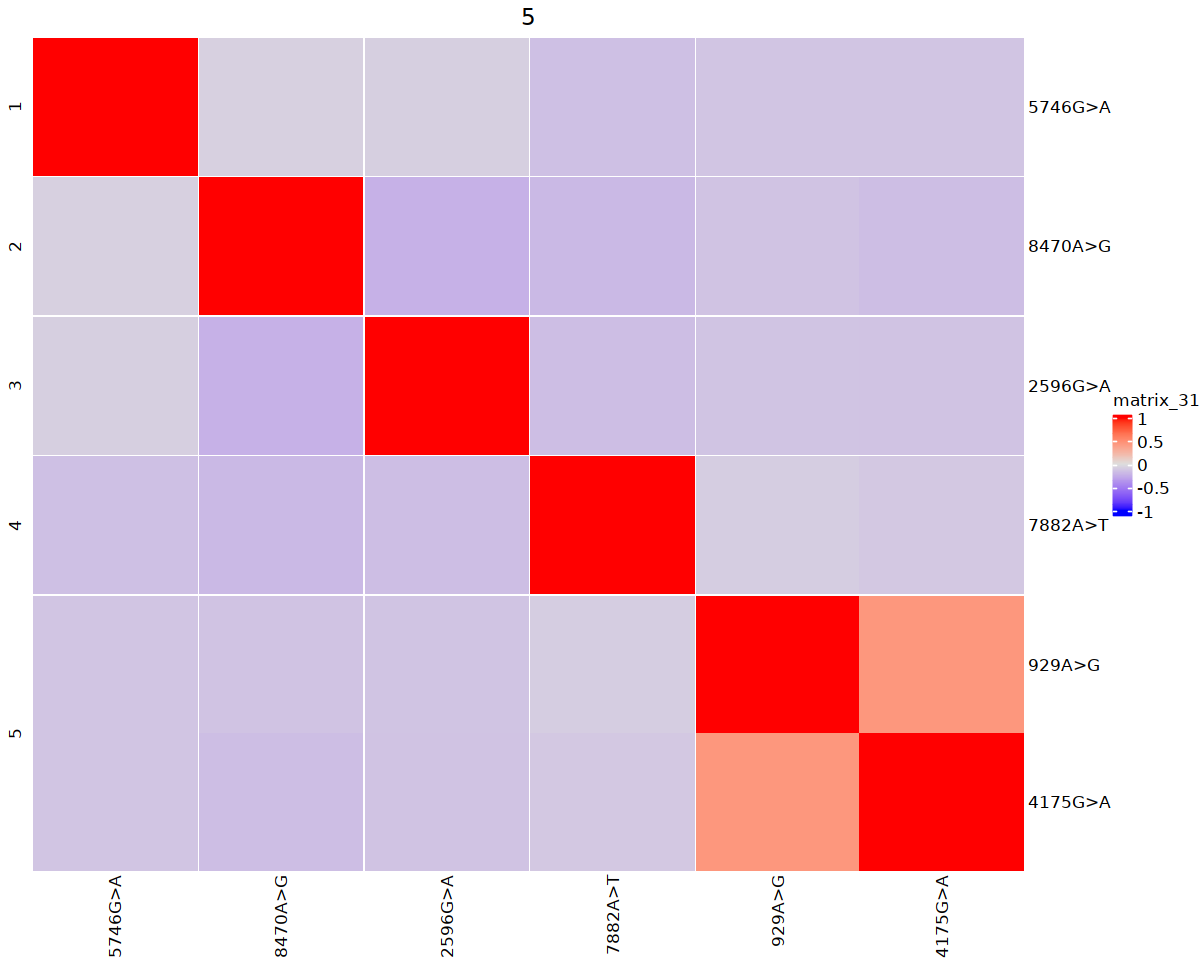

In [576]:

ngroups = length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



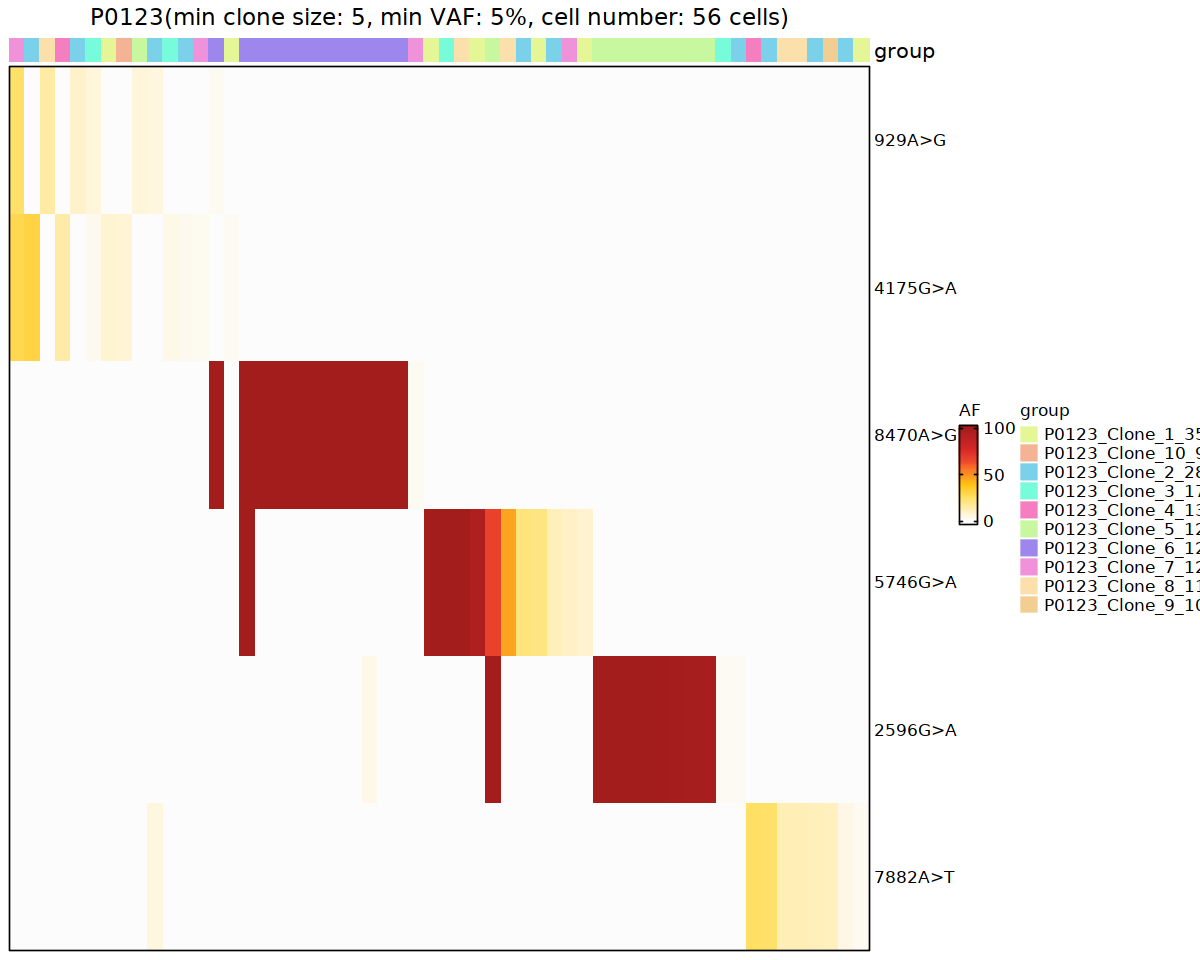

In [577]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

                                   
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

In [578]:

tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))

#remove clones with only one cell.
cell_num_dict = table(clone_info_df$Clone)
passed_CIV = c()
for (civ in CIV) {
    if (cell_num_dict[civ] >=2) {
        passed_CIV = append(passed_CIV, civ)
    }
}

small_clone_num = length(CIV) - length(passed_CIV)
CIV = passed_CIV
keep_cells = clone_info_df[clone_info_df$Clone %in% CIV, "Cell"]
small_clone_cell_num = ncol(new2) - length(keep_cells)
message(paste0("Removed ", small_clone_num, " small clones, and ", small_clone_cell_num, " cells falling within the small clones were removed."))
#remove cells from the small clones 
clone_info_df = clone_info_df[clone_info_df$Clone %in% CIV, ]
new2 = new2[CIV, keep_cells]
      
CIV_file_name = paste0(civ_dir,"/strong_exp_CIV_clones_", sample_name, ".csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)
new_plot_mat = new2


Removed 0 small clones, and 0 cells falling within the small clones were removed.

Clone info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10_strong//strong_exp_CIV_clones_P0123.csv



In [579]:
new_plot_mat1 = new_plot_mat/100 

all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.01]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.01]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(civ_dir,"/strong_exp_meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10_strong//strong_exp_meanvar_CIV_P0123.csv



In [580]:
shannon_e = c()

for (i in CIV) {
    cell = clone_info_df[clone_info_df$Clone == i, "Cell"]
    colony_comp = meta[cell, "Clone"]
    shannon_e = append(shannon_e, calculate_entropy(colony_comp))
}
diversity_df = data.frame(Diversity=shannon_e, row.names = CIV)
diversity_file_name = paste0(civ_dir,"/strong_exp_diversity_CIV_", sample_name, ".csv")
write.csv(diversity_df, file = diversity_file_name, quote =F)
message("Diversity info has been saved to: ", diversity_file_name)

Diversity info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10_strong//strong_exp_diversity_CIV_P0123.csv



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


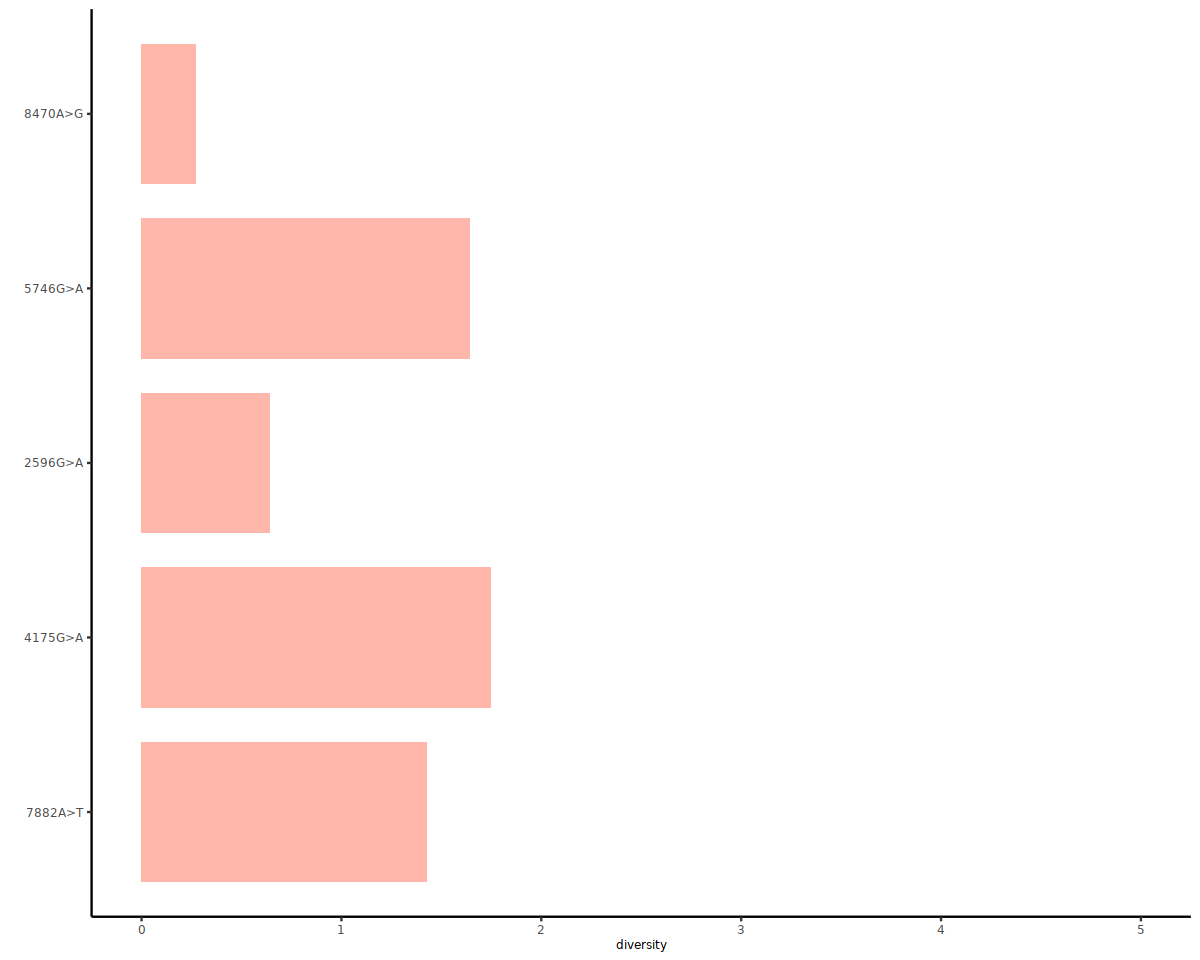

In [581]:
plot_df = data.frame(variant=CIV, diversity = shannon_e)
plot_df$variant = factor(plot_df$variant, levels = rev(CIV) )
diversity_plot = ggplot(plot_df, aes(x=variant, y=diversity)) + geom_bar(stat="identity", fill = "#ff715b", alpha=0.5, width = 0.8) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7)) + xlab("") + 
  scale_y_continuous(breaks = seq(0, 5, 0.5)) + ylim(0, 5) + coord_flip()
diversity_plot
ggsave(plot = diversity_plot, file = paste0(civ_dir, "/strong_exp_diversity_plot.pdf"), height = 3, width = 3)


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10_strong/P0123_strong_exp_CIV_heatmap.pdf



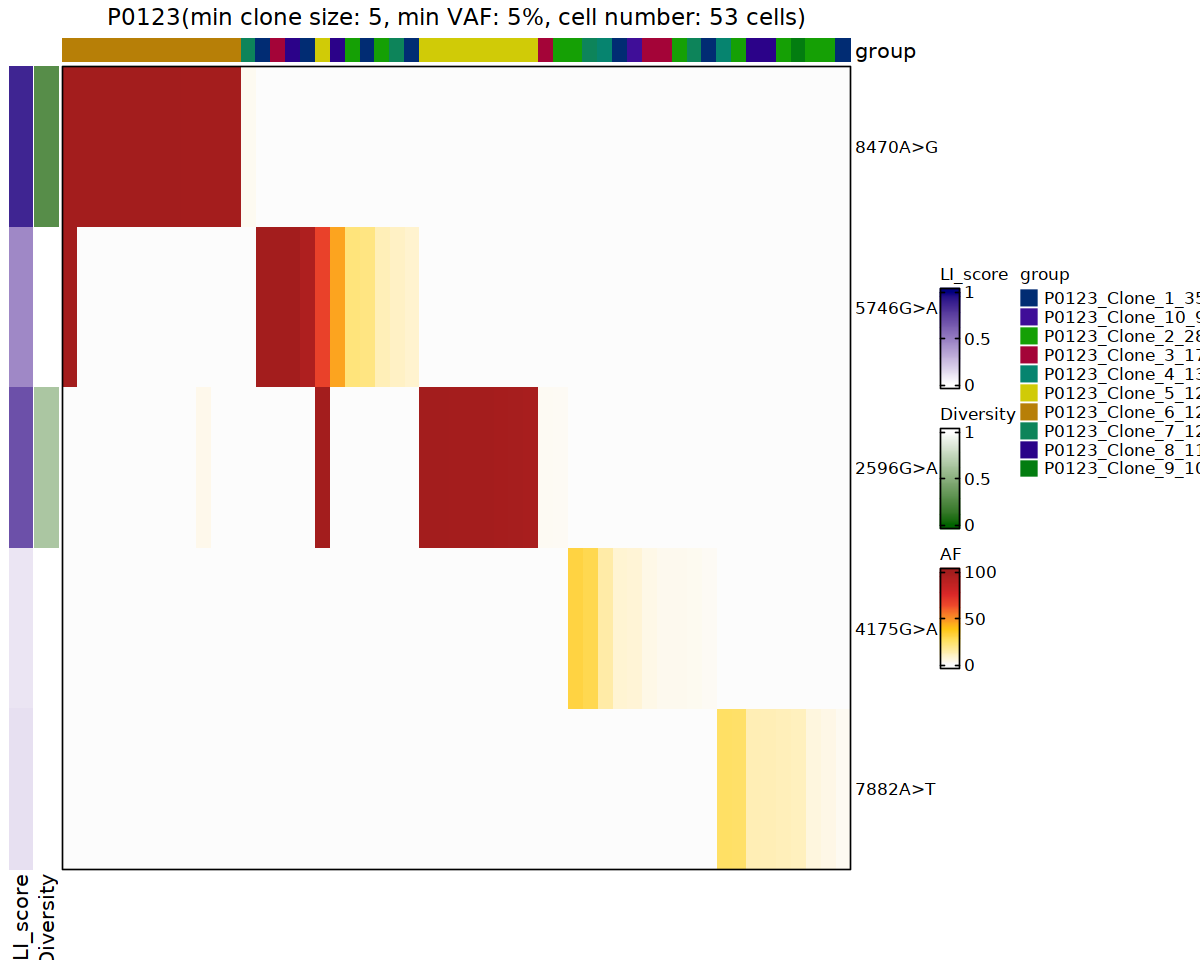

In [532]:
col_pal1 = colorRamp2(c(0, 1), c( "white", "navyblue"))
col_pal2 = colorRamp2(c(0, 1), c( "darkgreen", "white"))
row_annot <- rowAnnotation(
  df = data.frame(LI_score = sub_mv1_ls, Diversity = shannon_e),
  col = list(LI_score = col_pal1, Diversity = col_pal2), annotation_legend_param = list(border = "#000000"))

ct_plot_df = as.data.frame(tibble(group=meta[colnames(new_plot_mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(new_plot_mat)," cells)")
htmap_p = Heatmap(new_plot_mat, column_title = my_title, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
                  left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p

heatmap_name = paste0(civ_dir, sample_name,"_strong_exp_CIV_heatmap.pdf")
pdf(heatmap_name, height = 2.645, width = 4.5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))


# Zhang TCR - P0123 - Top10 excluded - Weakly expanded T cell subpopulations

In [494]:
sample_name = "P0123"
main_dir = paste0("/syn1/wangxin/work/GB_rev/Zhang/", sample_name, "/")
civ_dir = paste0(main_dir, "CIV_top10excluded_weak/")
#create CIV folder for
if (!dir.exists(civ_dir)) {
  # Create the directory
  dir.create(civ_dir, recursive = TRUE)
  }

setwd(main_dir)
df = read.csv(paste0(main_dir,"outs/", sample_name, "_mtSNV_final.csv"), row.names = 1, check.names = F)

meta = read.csv(paste0("/syn1/wangxin/work/GB_rev/Zhang/trust4/", sample_name, "_meta.csv"), row.names = 1, check.names = F, header = T)
meta = meta[as.numeric(sapply(meta$Clone, function(x) {strsplit(x, "_")[[1]][3]}) ) > 10,]

common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)
af.dm[af.dm < 1] = 0
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time
           

Time difference of 1.267761 secs

In [495]:
conditions.tib <- tibble(min_clone_size = rep(seq(5, 10, by = 1), 5),
                         min_vaf = rep(c("n1", "n5", "n10", "n20", "n50"), each = 6),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm)) # change this from 0.9 to 0.6 to include more variants
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA

        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code

        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )

        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}

conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls



In [496]:
conditions.tib

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n1,"705C>T, ....",1409,NTC117-2....,966,0.9339957
6,n1,"705C>T, ....",1107,NTC117-2....,966,0.9403794
7,n1,"705C>T, ....",893,NTC117-2....,966,0.9428891
8,n1,"705C>T, ....",725,NTC117-2....,966,0.9406897
9,n1,"705C>T, ....",629,NTC117-2....,966,0.9427663
10,n1,"727T>C, ....",560,NTC117-2....,966,0.9410714
5,n5,"747A>G, ....",138,NTC117-2....,953,0.7898551
6,n5,"747A>G, ....",89,NTC117-2....,929,0.7528090
7,n5,"797C>T, ....",57,NTC117-2....,848,0.7543860


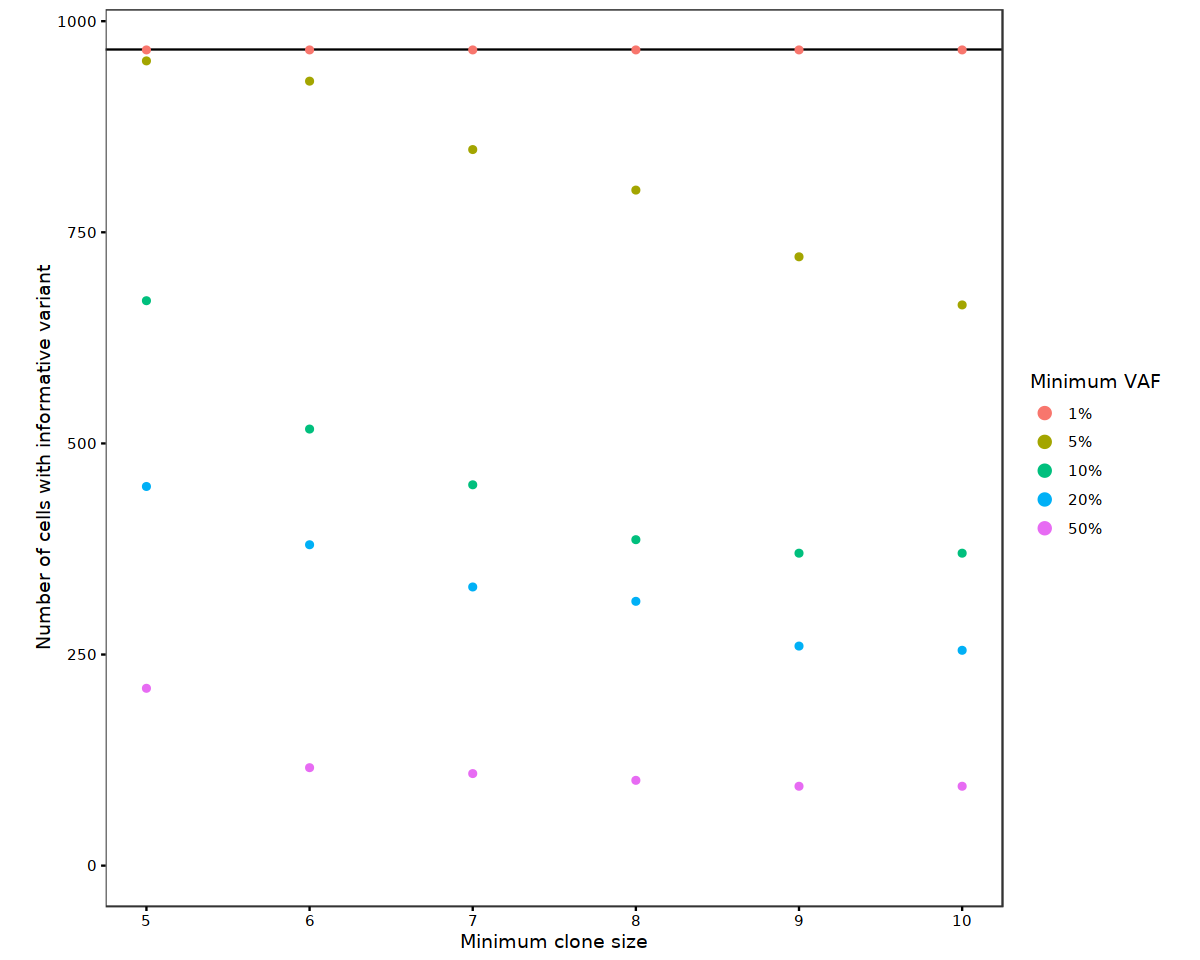

In [497]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "20%", "50%")))

ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [498]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(5, 10), min_vaf %in% c("n5","n10", "n20"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"747A>G, ....",138,NTC117-2....,953,0.7898551
10,n5,"929A>G, ....",27,NTC117-2....,664,0.7777778
5,n10,"929A>G, ....",32,NTC117-2....,669,0.8125000
10,n10,"929A>G, ....",11,NTC117-2....,370,0.7272727
5,n20,"929A>G, ....",20,NTC117-2....,449,0.7500000
10,n20,"929A>G, ....",6,NTC117-2....,255,0.6666667


## min clone 10 min vaf 5%

In [499]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=2
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



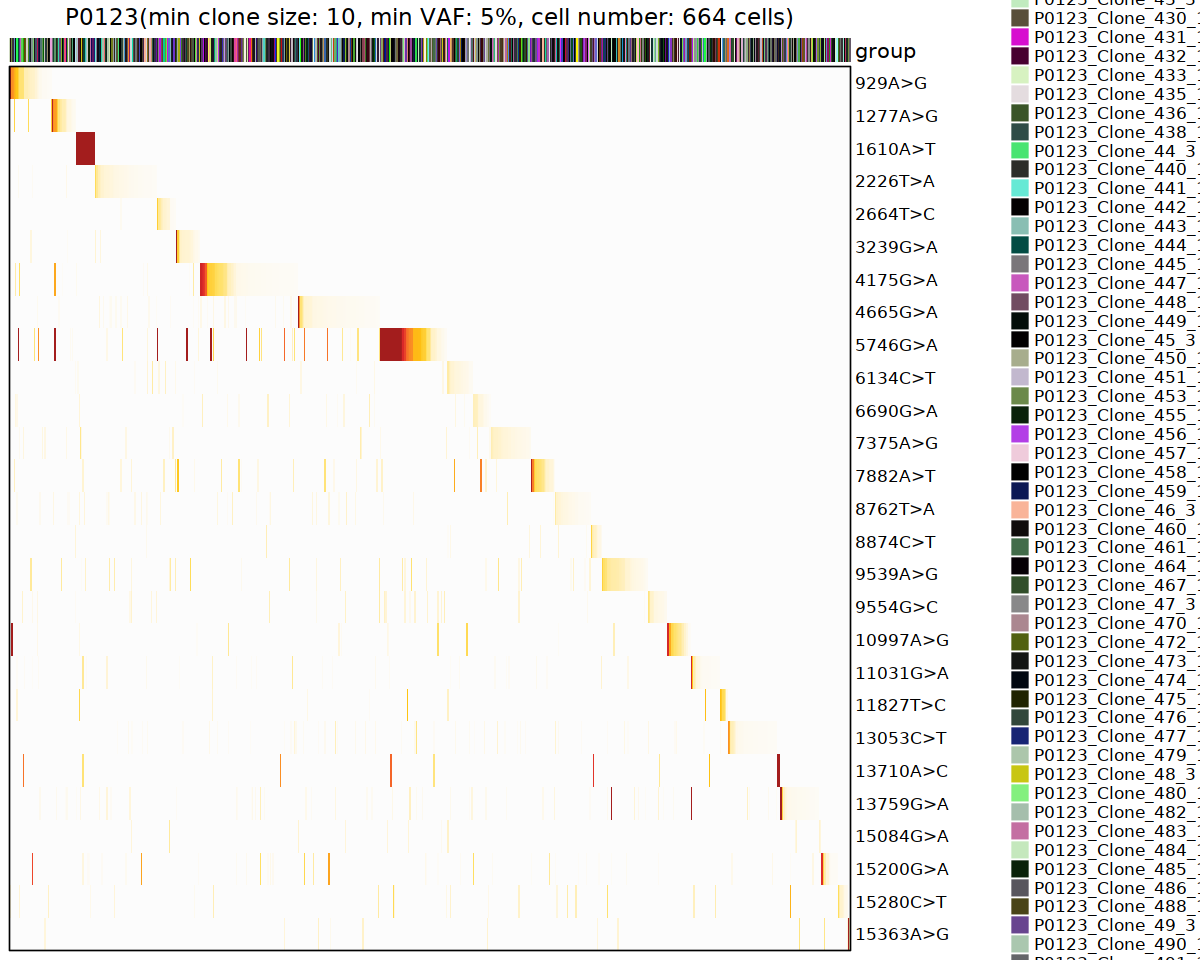

In [500]:
options(repr.plot.width=10, repr.plot.height=8)
ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
#ha <- HeatmapAnnotation(df = ct_plot_df, col = list(group = ct_pal))
ha <- HeatmapAnnotation(df = ct_plot_df)
clone_size_cutoff = conditions_subset.tib$min_clone_size[a]
vaf_cutoff = substr(conditions_subset.tib$min_vaf[a],2,nchar(conditions_subset.tib$min_vaf[a]))
my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(plot_order.mat)," cells)")
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(240, "mm"),
               #height = unit(200, "mm"),
               use_raster = T,
               raster_quality = 5)

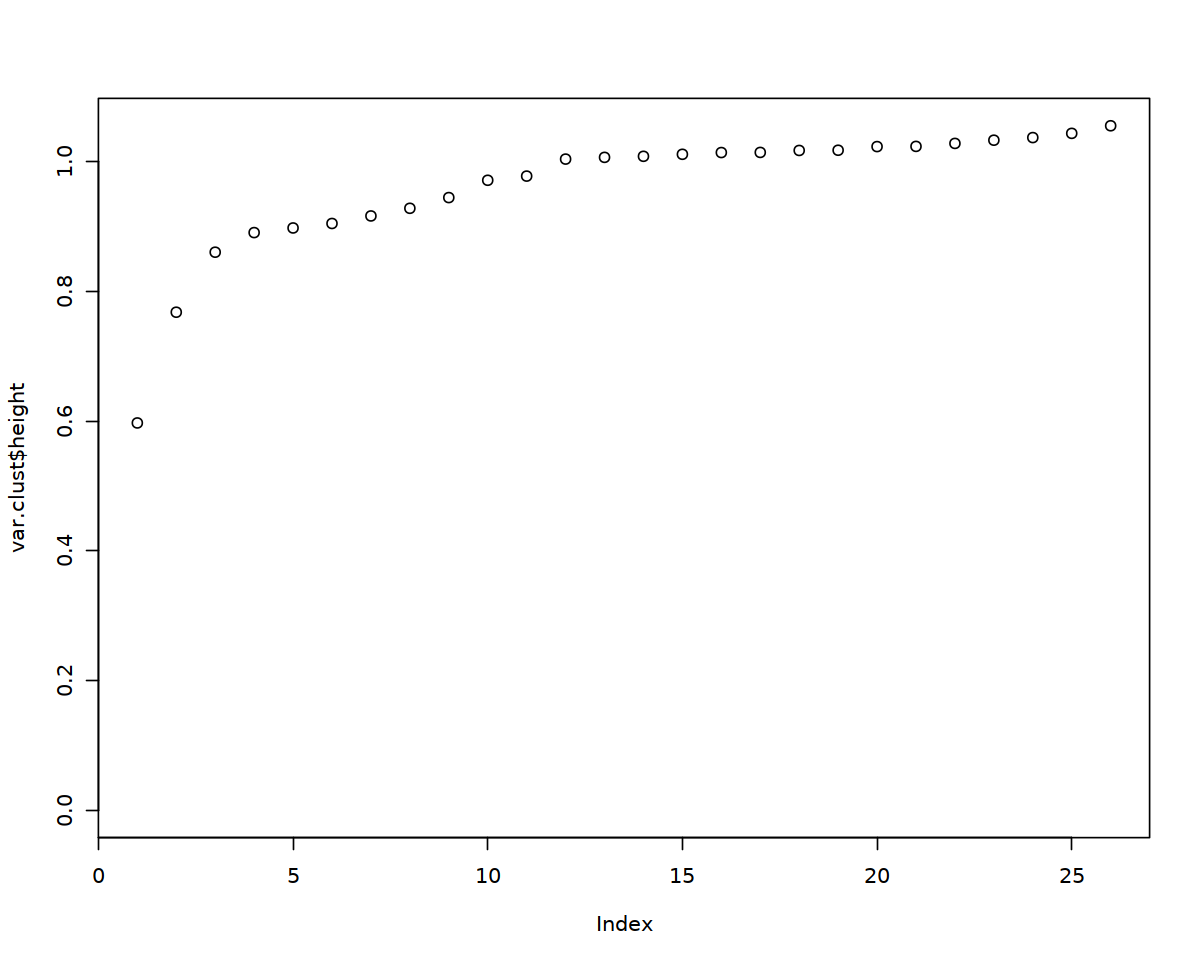

In [501]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

plot(var.clust$height, ylim = c(0, max(var.clust$height)))

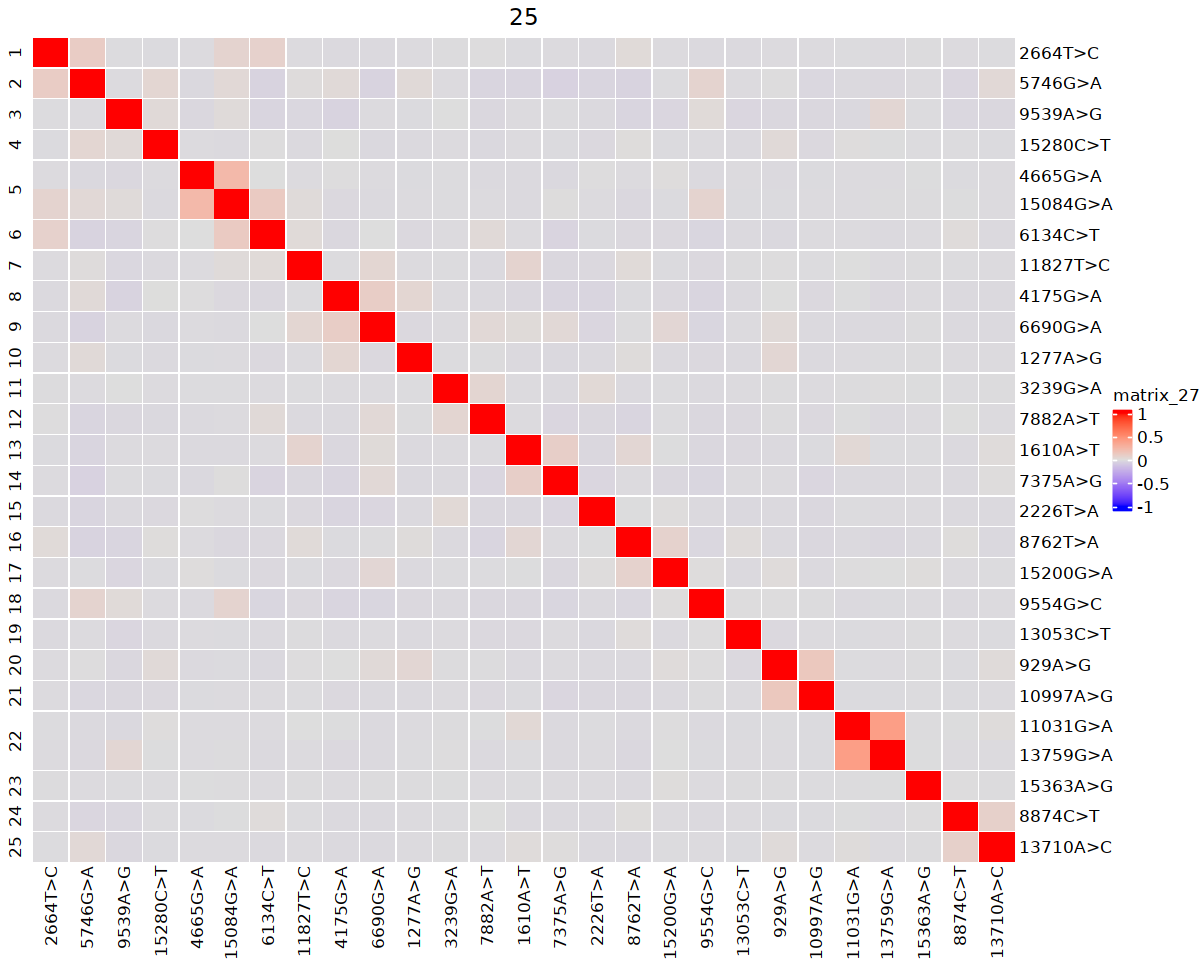

In [502]:

ngroups = length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



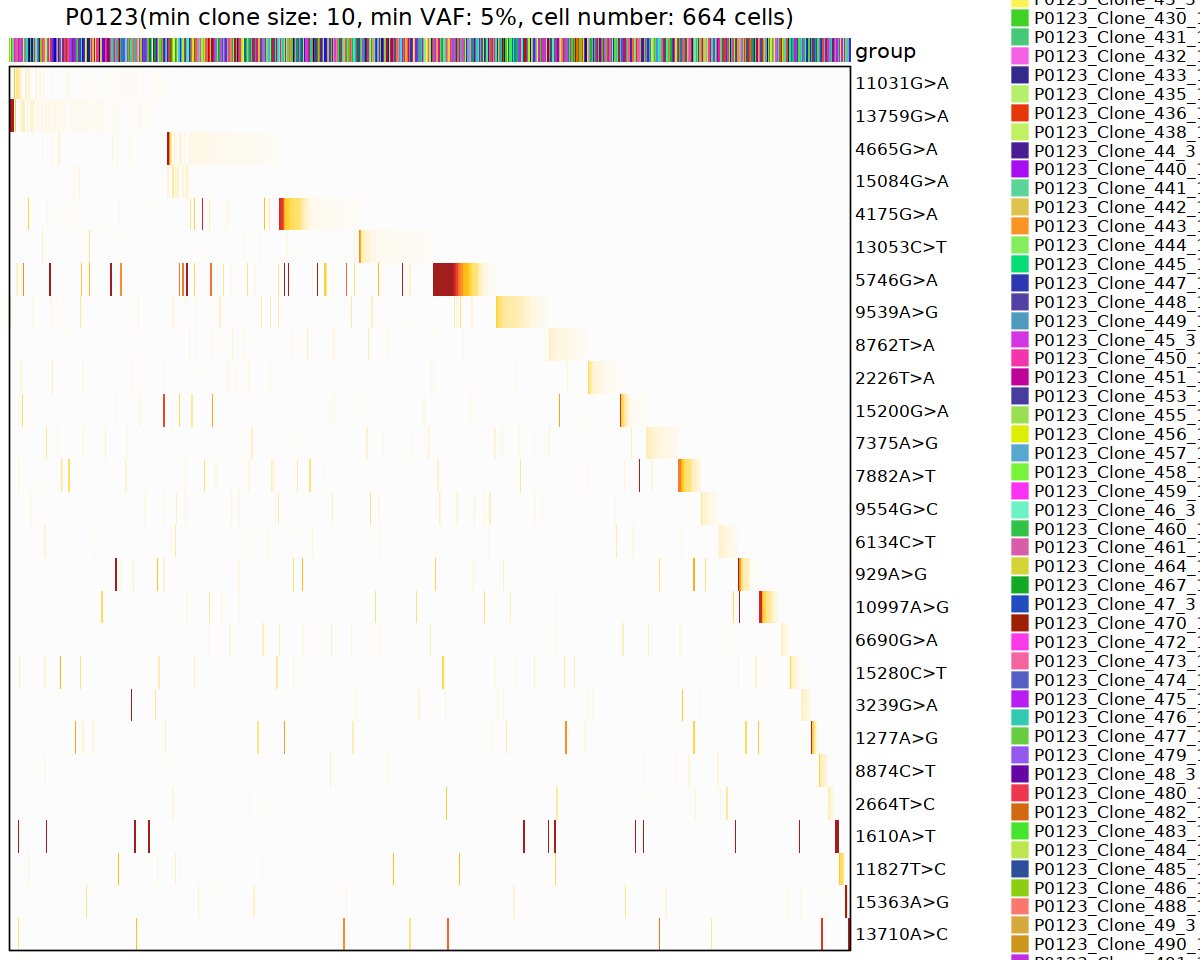

In [503]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

ct_plot_df = as.data.frame(tibble(group=meta[colnames(plot_order.mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

                                   
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

In [504]:

tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))

#remove clones with only one cell.
cell_num_dict = table(clone_info_df$Clone)
passed_CIV = c()
for (civ in CIV) {
    if (cell_num_dict[civ] >=2) {
        passed_CIV = append(passed_CIV, civ)
    }
}

small_clone_num = length(CIV) - length(passed_CIV)
CIV = passed_CIV
keep_cells = clone_info_df[clone_info_df$Clone %in% CIV, "Cell"]
small_clone_cell_num = ncol(new2) - length(keep_cells)
message(paste0("Removed ", small_clone_num, " small clones, and ", small_clone_cell_num, " cells falling within the small clones were removed."))
#remove cells from the small clones 
clone_info_df = clone_info_df[clone_info_df$Clone %in% CIV, ]
new2 = new2[CIV, keep_cells]
      
CIV_file_name = paste0(civ_dir,"/strong_exp_CIV_clones_", sample_name, ".csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)
new_plot_mat = new2


Removed 0 small clones, and 0 cells falling within the small clones were removed.

Clone info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10excluded_weak//strong_exp_CIV_clones_P0123.csv



In [505]:
new_plot_mat1 = new_plot_mat/100 

all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.01]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.01]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(civ_dir,"/strong_exp_meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10excluded_weak//strong_exp_meanvar_CIV_P0123.csv



In [506]:
shannon_e = c()

for (i in CIV) {
    cell = clone_info_df[clone_info_df$Clone == i, "Cell"]
    colony_comp = meta[cell, "Clone"]
    shannon_e = append(shannon_e, calculate_entropy(colony_comp))
}
diversity_df = data.frame(Diversity=shannon_e, row.names = CIV)
diversity_file_name = paste0(civ_dir,"/strong_exp_diversity_CIV_", sample_name, ".csv")
write.csv(diversity_df, file = diversity_file_name, quote =F)
message("Diversity info has been saved to: ", diversity_file_name)

Diversity info has been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10excluded_weak//strong_exp_diversity_CIV_P0123.csv



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


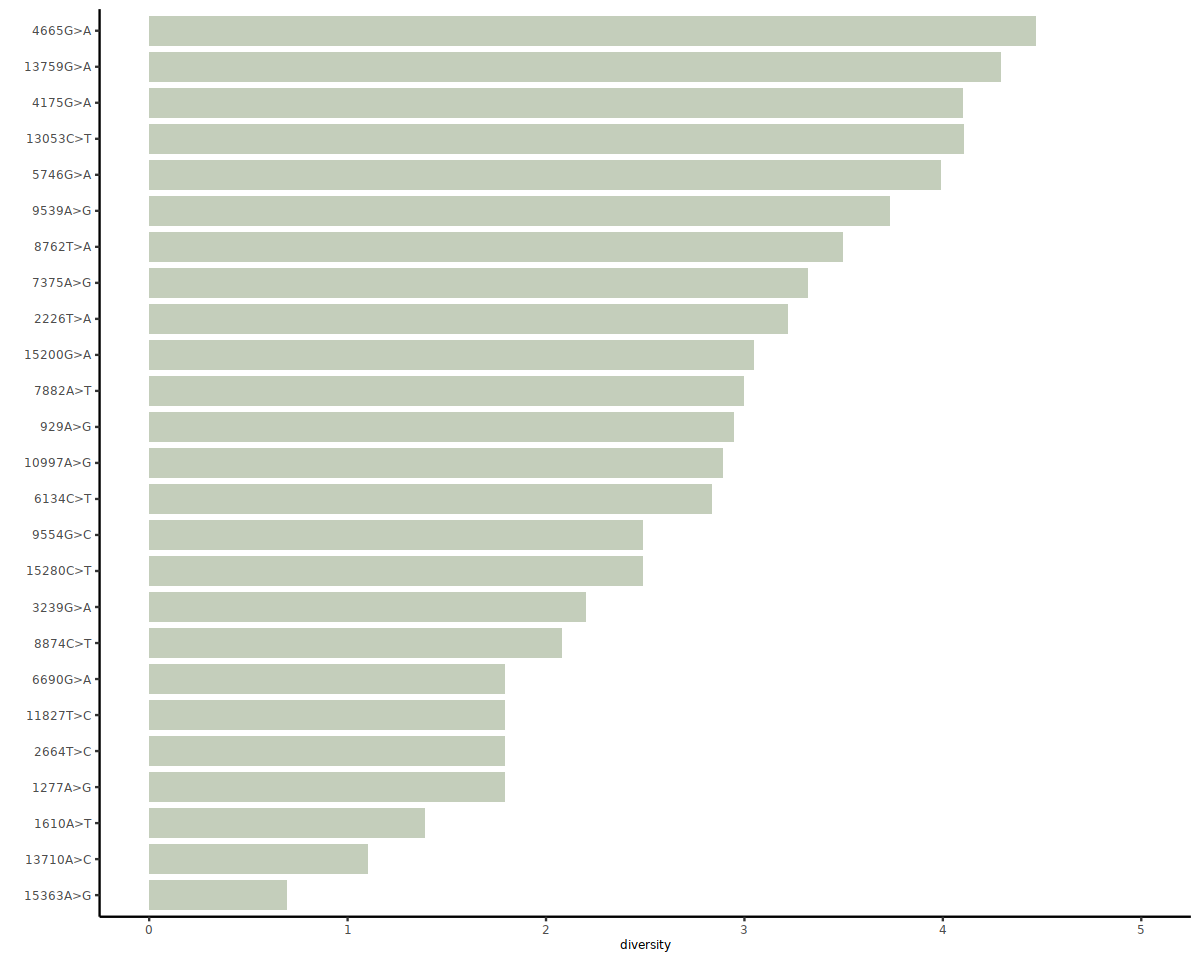

In [512]:
plot_df = data.frame(variant=CIV, diversity = shannon_e)
plot_df$variant = factor(plot_df$variant, levels = rev(CIV) )
diversity_plot = ggplot(plot_df, aes(x=variant, y=diversity)) + geom_bar(stat="identity", fill = "#899d78", alpha=0.5, width = 0.8) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7)) + xlab("") + 
  scale_y_continuous(breaks = seq(0, ceiling(max(shannon_e)), 0.5)) + ylim(0, ceiling(max(shannon_e))) + coord_flip()
diversity_plot
ggsave(plot = diversity_plot, file = paste0(civ_dir, "/weak_exp_diversity_plot.pdf"), height = 3, width = 3)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/GB_rev/Zhang/P0123/CIV_top10excluded_weak/P0123_strong_exp_CIV_heatmap.pdf



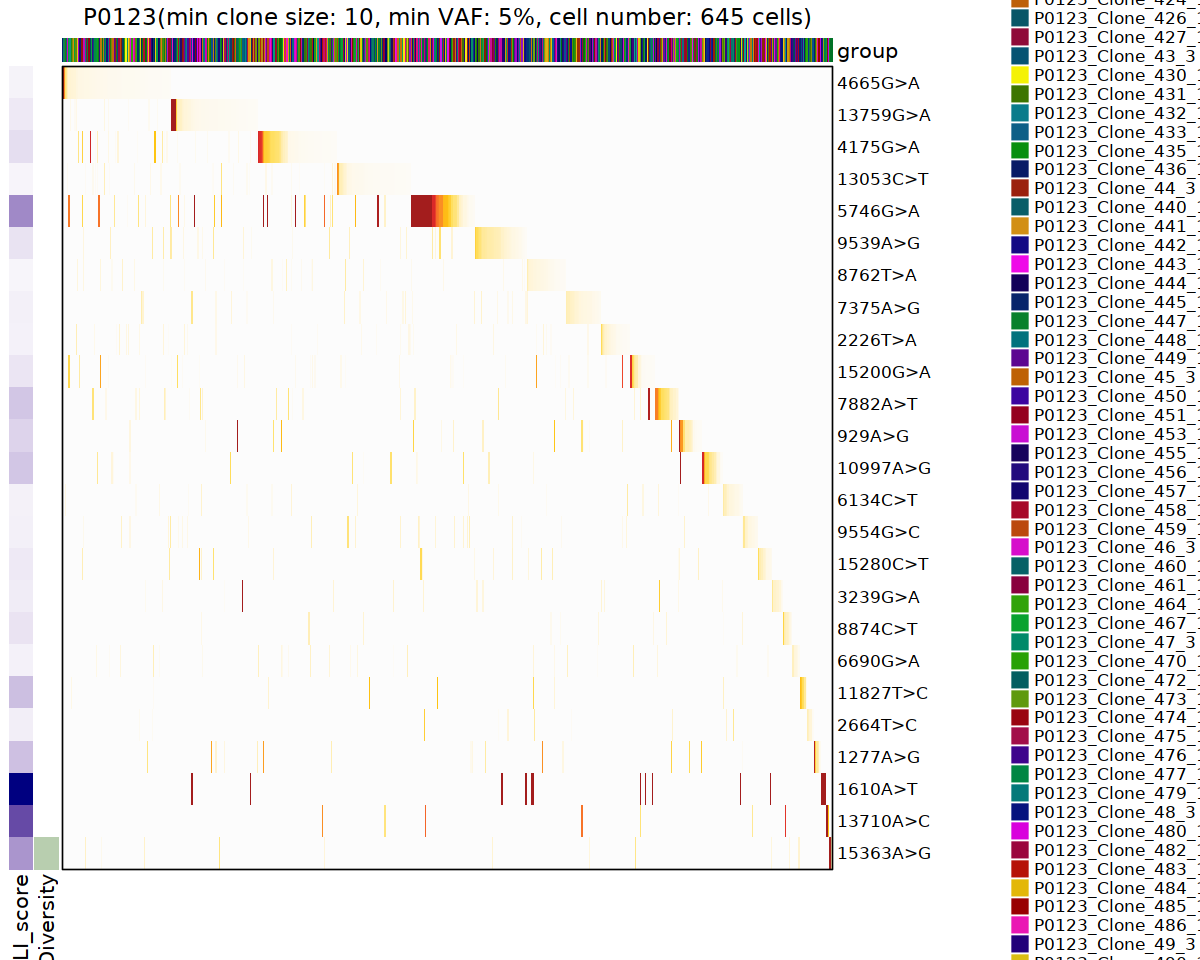

In [510]:
col_pal1 = colorRamp2(c(0, 1), c( "white", "navyblue"))
col_pal2 = colorRamp2(c(0, 1), c( "darkgreen", "white"))
row_annot <- rowAnnotation(
  df = data.frame(LI_score = sub_mv1_ls, Diversity = shannon_e),
  col = list(LI_score = col_pal1, Diversity = col_pal2), annotation_legend_param = list(border = "#000000"))

ct_plot_df = as.data.frame(tibble(group=meta[colnames(new_plot_mat),"Clone"]))
ha <- HeatmapAnnotation(df = ct_plot_df)

my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(new_plot_mat)," cells)")
htmap_p = Heatmap(new_plot_mat, column_title = my_title, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
                  left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p

heatmap_name = paste0(civ_dir, sample_name,"_strong_exp_CIV_heatmap.pdf")
pdf(heatmap_name, height = 2.645, width = 4.5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))
